## Time series forecasting

Dataset: [Madrid weather dataset hourly 2019-2022](https://www.kaggle.com/datasets/rober2598/madrid-weather-dataset-by-hours-20192022/data)


Podaci sa meteorološke stanice Moratalaz u Madridu za period januar 2019-januar 2022.

Atributi:

1. temperature (ºC)
2. wind speed (m/s)
3. wind direction (in degrees)
4. humidity (%)
5. barometric pressure (mb)
6. solar radiation (W/m^2)
7. precipitation (l/m^2)

In [186]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')
tf.random.set_seed(13)

### Učitavanje i priprema podataka

In [152]:
data = pd.read_csv("weather_madrid_2019-2022.csv", index_col=1)

In [153]:
data.index = pd.to_datetime(data.index)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27024 entries, 2019-01-01 00:59:59 to 2022-01-31 23:59:59
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           27024 non-null  int64  
 1   temperature          27024 non-null  float64
 2   wind_speed           27024 non-null  float64
 3   wind_direction       27024 non-null  float64
 4   humidity             27024 non-null  float64
 5   barometric_pressure  27024 non-null  float64
 6   solar_radiation      27024 non-null  float64
 7   precipitation        27024 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [5]:
print(f"Number of missing values in dataset:\n{data.isna().sum()}")

Number of missing values in dataset:
Unnamed: 0             0
temperature            0
wind_speed             0
wind_direction         0
humidity               0
barometric_pressure    0
solar_radiation        0
precipitation          0
dtype: int64


In [6]:
data.head()

Unnamed: 0  temperature  wind_speed  wind_direction  \
time                                                                       
2019-01-01 00:59:59           0          3.1        0.65            64.0   
2019-01-01 01:59:59           1          2.9        0.95            32.0   
2019-01-01 02:59:59           2          3.1        0.87            62.0   
2019-01-01 03:59:59           3          1.9        0.73            75.0   
2019-01-01 04:59:59           4          0.7        0.57            53.0   

                     humidity  barometric_pressure  solar_radiation  \
time                                                                  
2019-01-01 00:59:59      50.0                949.0              0.0   
2019-01-01 01:59:59      49.0                949.0              0.0   
2019-01-01 02:59:59      46.0                949.0              0.0   
2019-01-01 03:59:59      51.0                949.0              0.0   
2019-01-01 04:59:59      56.0                949.0              0.0   

                     precipitation  
time                                
2019-01-01 00:59:59            0.0  
2019-01-01 01:59:59            0.0  
2019-01-01 02:59:59            0.0  
2019-01-01 03:59:59            0.0  
2019-01-01 04:59:59            0.0

In [154]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
data.head()

temperature  wind_speed  wind_direction  humidity  \
time                                                                     
2019-01-01 00:59:59          3.1        0.65            64.0      50.0   
2019-01-01 01:59:59          2.9        0.95            32.0      49.0   
2019-01-01 02:59:59          3.1        0.87            62.0      46.0   
2019-01-01 03:59:59          1.9        0.73            75.0      51.0   
2019-01-01 04:59:59          0.7        0.57            53.0      56.0   

                     barometric_pressure  solar_radiation  precipitation  
time                                                                      
2019-01-01 00:59:59                949.0              0.0            0.0  
2019-01-01 01:59:59                949.0              0.0            0.0  
2019-01-01 02:59:59                949.0              0.0            0.0  
2019-01-01 03:59:59                949.0              0.0            0.0  
2019-01-01 04:59:59                949.0              0.0            0.0

In [9]:
data.tail()

temperature  wind_speed  wind_direction  humidity  \
time                                                                     
2022-01-31 19:59:59         10.1        2.65            47.0      17.0   
2022-01-31 20:59:59          8.2        3.82            21.0      25.0   
2022-01-31 21:59:59          7.2        2.38            29.0      31.0   
2022-01-31 22:59:59          5.6        3.92            58.0      41.0   
2022-01-31 23:59:59          4.9        3.95            11.0      47.0   

                     barometric_pressure  solar_radiation  precipitation  
time                                                                      
2022-01-31 19:59:59                946.0              0.0            0.0  
2022-01-31 20:59:59                947.0              0.0            0.0  
2022-01-31 21:59:59                947.0              0.0            0.0  
2022-01-31 22:59:59                947.0              0.0            0.0  
2022-01-31 23:59:59                948.0              0.0            0.0

In [10]:
data.describe()

temperature    wind_speed  wind_direction      humidity  \
count  27024.000000  27024.000000    27024.000000  27024.000000   
mean      12.817040      2.058503      142.523313     54.560909   
std        8.195516      1.253231       92.795447     22.700106   
min       -9.100000      0.000000        0.000000      0.000000   
25%        6.400000      1.100000       62.000000     36.000000   
50%       11.400000      1.800000      122.000000     53.000000   
75%       18.800000      2.770000      241.000000     72.000000   
max       37.900000      9.450000      359.000000    100.000000   

       barometric_pressure  solar_radiation  precipitation  
count         27024.000000     27024.000000   27024.000000  
mean            940.013433       197.641282       0.045811  
std              17.668038       284.877404       0.463671  
min               0.000000         0.000000       0.000000  
25%             938.000000         0.000000       0.000000  
50%             941.000000         9.000000       0.000000  
75%             944.000000       355.000000       0.000000  
max             952.000000      1068.000000      27.400000

In [11]:
data.skew()

temperature             0.461747
wind_speed              1.008883
wind_direction          0.248713
humidity                0.152653
barometric_pressure   -29.898869
solar_radiation         1.311261
precipitation          30.785920
dtype: float64

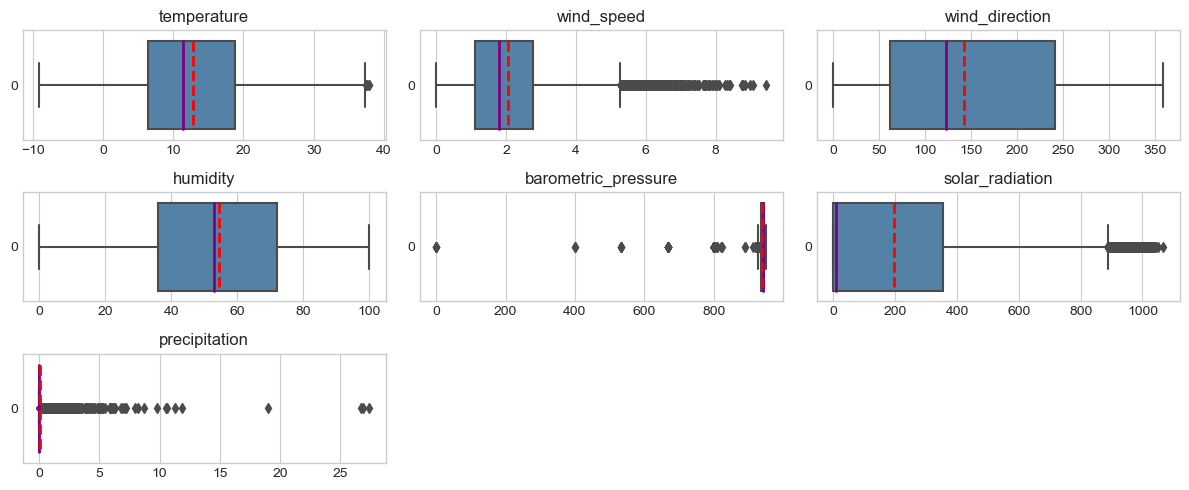

In [12]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(3, 3, i+1)
    plt.title(feature)
    sns.boxplot(data[feature], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
plt.tight_layout()

In [155]:
Q1 = data['barometric_pressure'].quantile(0.25)
Q3 = data['barometric_pressure'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

upper_array = data[data['barometric_pressure'] >= upper].index
lower_array = data[data['barometric_pressure'] <= lower].index

mean = data.loc[:, 'barometric_pressure'].mean()
data.loc[upper_array, 'barometric_pressure'] = mean
data.loc[lower_array, 'barometric_pressure'] = mean

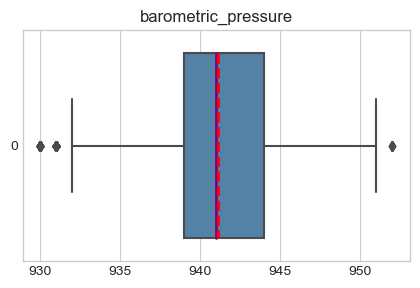

In [14]:
plt.figure(figsize=(5, 3))
plt.title("barometric_pressure")
sns.boxplot(data["barometric_pressure"], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

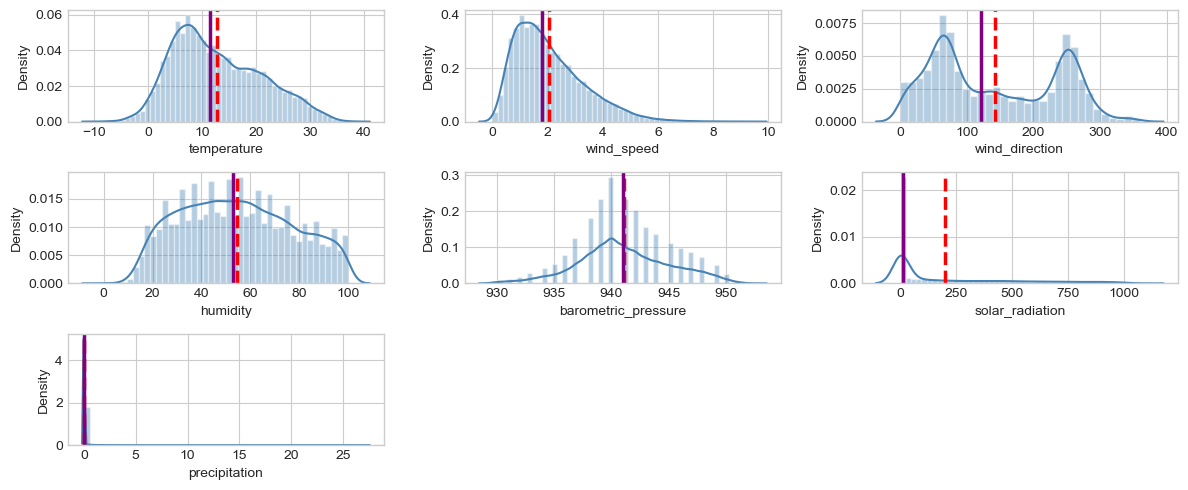

In [15]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(3, 3, i+1)
    sns.distplot(data[feature], color="steelblue")
    plt.axvline(x=data[feature].mean(), c='red', ls='--', lw=2.5)
    plt.axvline(x=data[feature].median(), c='purple', ls='-', lw=2.5)
plt.tight_layout()

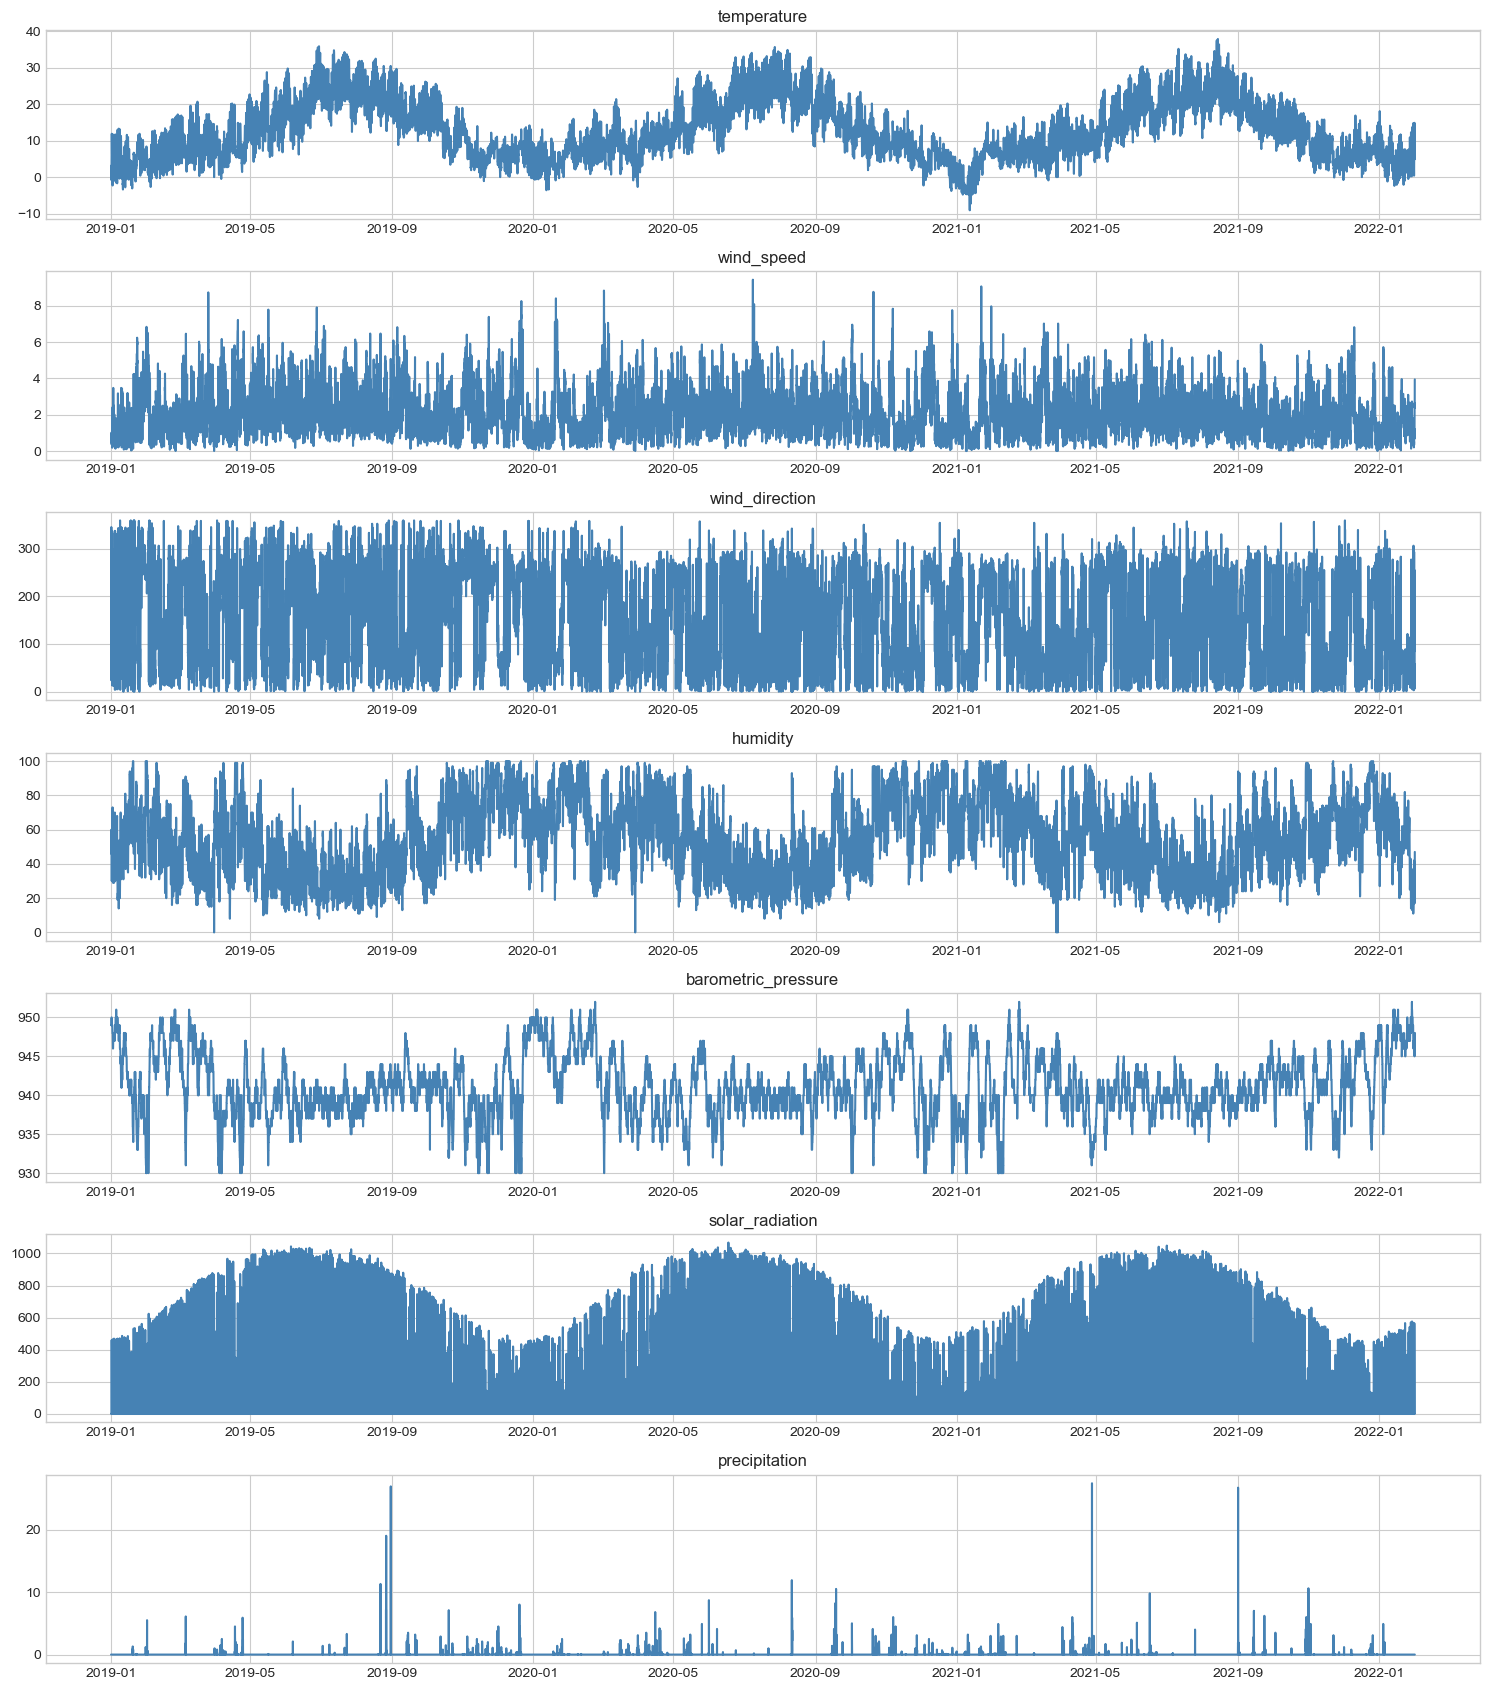

In [16]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(data.index, data[feature].values, color="steelblue")
plt.tight_layout()

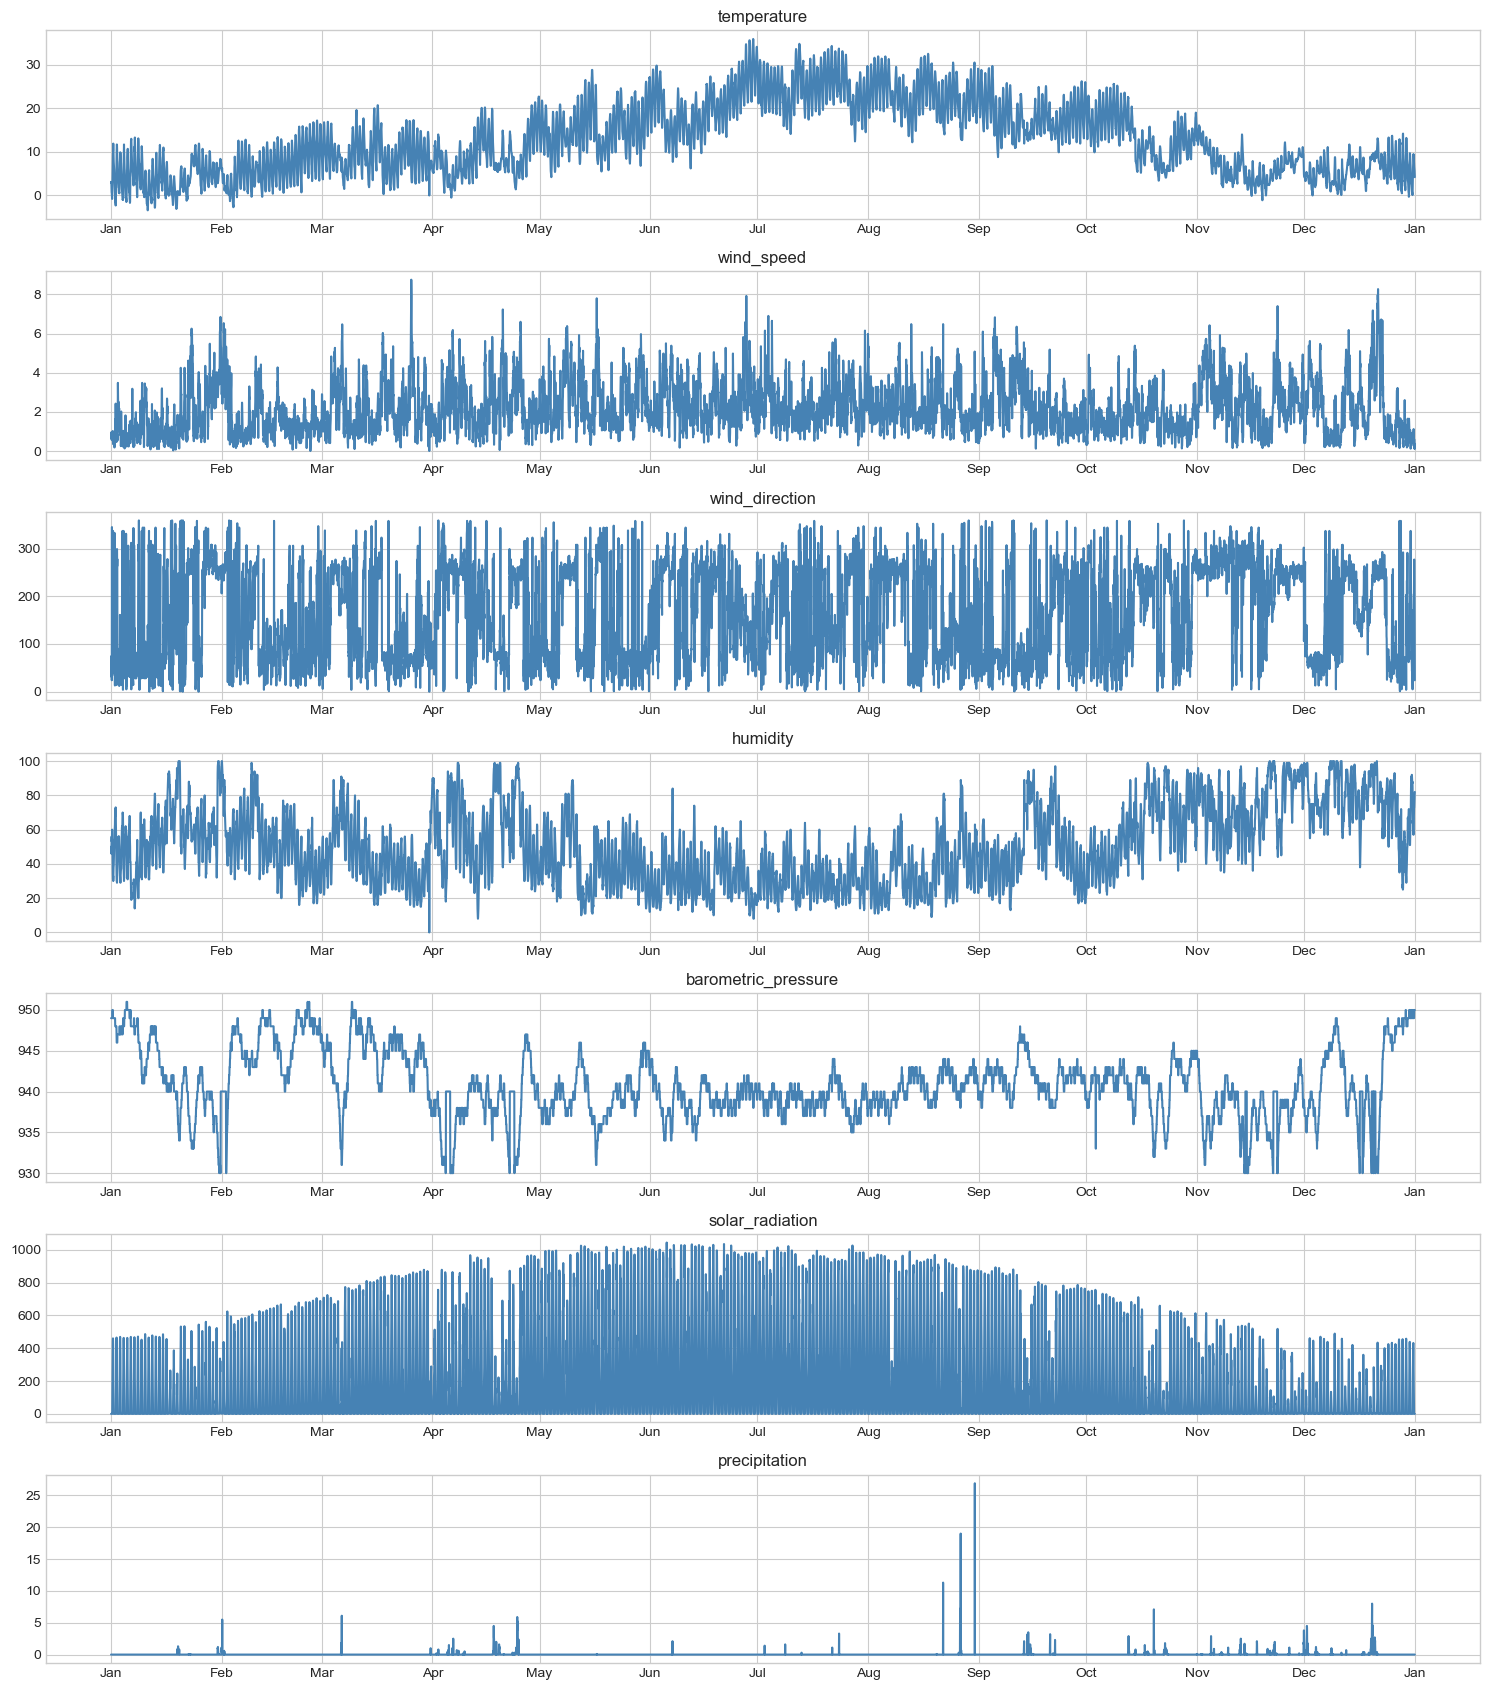

In [17]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    ax = plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(list(data.index.values[0:365*24]), data[feature].values[0:365*24], color="steelblue")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()

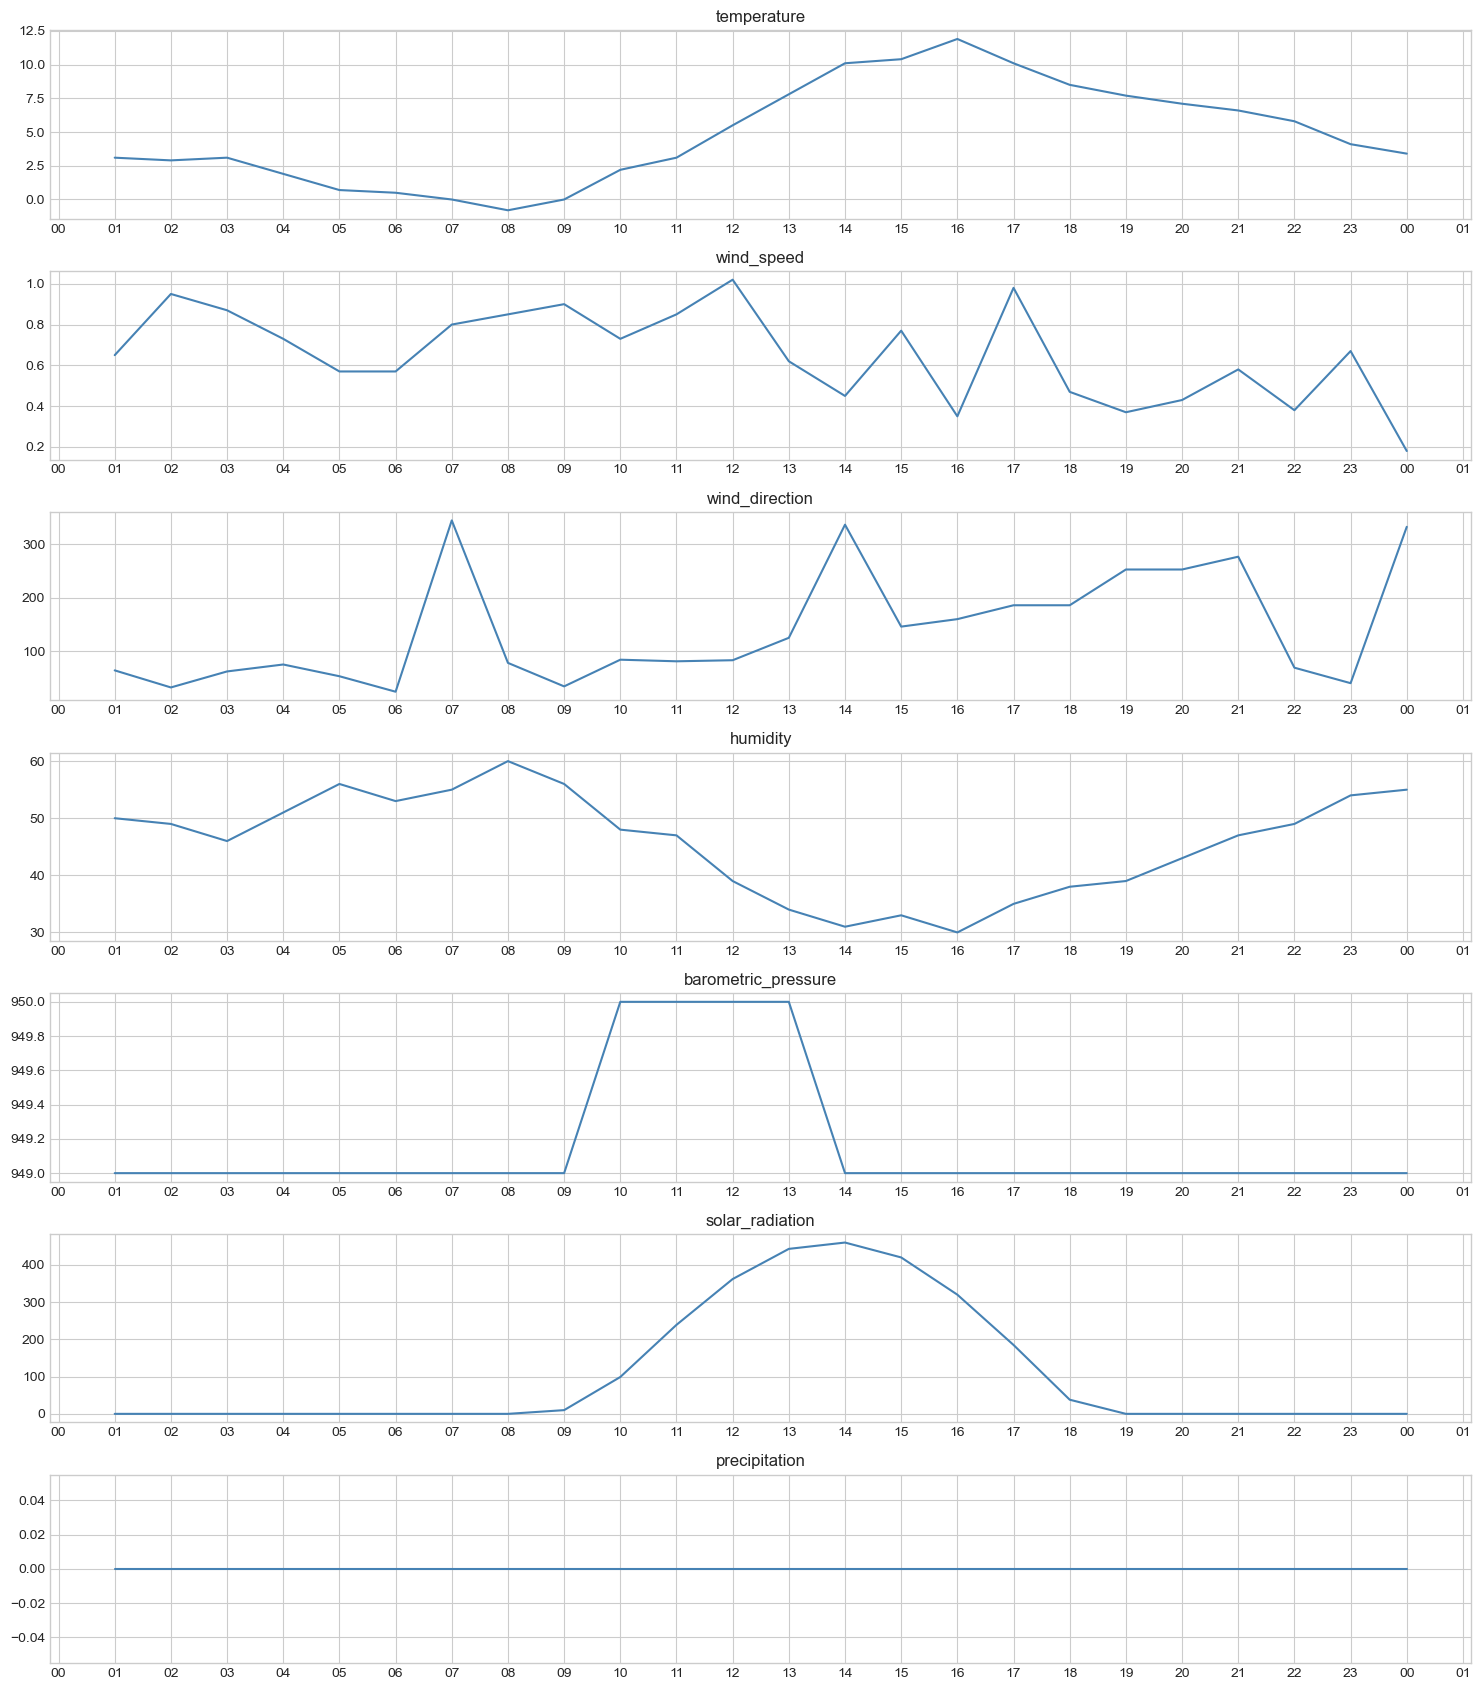

In [160]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    ax = plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(list(data.index.values[0:24]), data[feature].values[0:24], color="steelblue")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.tight_layout()

Transformacija smera i brzine vetra u vektor:

In [162]:
wv = data.pop('wind_speed')
wd_rad = data.pop('wind_direction')*np.pi / 180

data['wind_x'] = wv*np.cos(wd_rad)
data['wind_y'] = wv*np.sin(wd_rad)

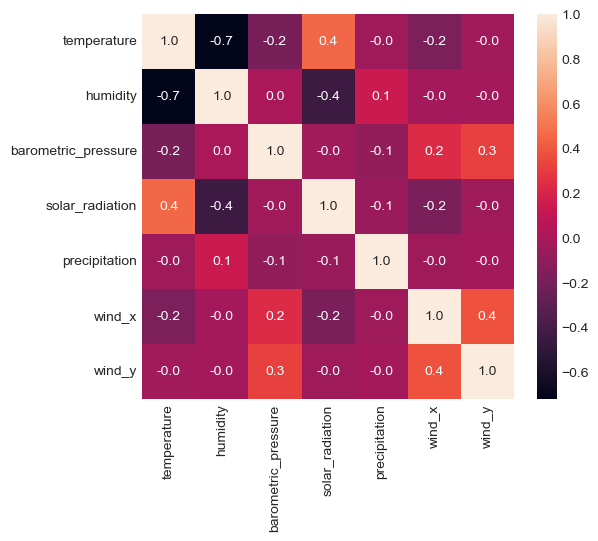

In [164]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr(), annot = True, fmt='.1f')
plt.show()

In [165]:
data.drop(["precipitation", "wind_y"], axis=1, inplace=True)

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27024 entries, 2019-01-01 00:59:59 to 2022-01-31 23:59:59
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature          27024 non-null  float64
 1   humidity             27024 non-null  float64
 2   barometric_pressure  27024 non-null  float64
 3   solar_radiation      27024 non-null  float64
 4   wind_x               27024 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


### Helpers

In [21]:
def series_to_supervised(data, index, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df.index = index
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [179]:
def prepare_dataset(reframed):
    values = reframed.values

    n = len(data)
    train = values[0:int(n*0.7)] # 70%
    val = values[int(n*0.7):int(n*0.9)] # 20%
    test = values[int(n*0.9):] # 10%

    inv_train_y = values[0:int(n*0.9), -1]

    train_min = train.min(axis=0)
    train_max = train.max(axis=0)

    train = (train - train_min) / (train_max - train_min)
    val = (val - train_min) / (train_max - train_min)
    test = (test - train_min) / (train_max - train_min)

    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

    ret_val = {"train_X": train_X,
               "train_y": train_y,
               "test_X": test_X,
               "test_y": test_y,
               "val_X": val_X,
               "val_y": val_y,
               "inv_train_y": inv_train_y,
               "values_min": train_min,
               "values_max": train_max,
               "n_train_hours": int(n*0.9)}

    return ret_val

In [23]:
def get_callbacks():
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
    callbacks = [early_stopping, model_checkpoint]

    return callbacks

In [288]:
def train_SimpleRNN_model(train_X, train_y, val_X, val_y, optimizer, loss):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(SimpleRNN(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, 
                        shuffle=False, callbacks=get_callbacks())

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

In [287]:
def train_LSTM_model(train_X, train_y, val_X, val_y, optimizer, loss):
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, 
                        shuffle=False, callbacks=get_callbacks())

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

In [289]:
def train_GRU_model(train_X, train_y, val_X, val_y, optimizer, loss):
    model = Sequential()
    model.add(GRU(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.3))
    model.add(GRU(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False, callbacks=get_callbacks())

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

In [27]:
def calculate_metrics(inv_y, inv_pred_y):
    mae = mean_absolute_error(inv_y, inv_pred_y)
    mse = mean_squared_error(inv_y, inv_pred_y)
    rmse = math.sqrt(mean_squared_error(inv_y, inv_pred_y))
    r2 = r2_score(inv_y, inv_pred_y)

    print('Test MAE: %.3f' % mae)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test R2: %.3f' % r2)

    return [mae, mse, rmse, r2]

In [28]:
def evaluate_model(model, values_min, values_max, test_X, test_y):
    pred_y = model.predict(test_X)

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = test_y * (values_max[-1] - values_min[-1]) + values_min[-1]
    pred_y = pred_y.reshape((len(pred_y), 1))
    inv_pred_y = pred_y * (values_max[-1] - values_min[-1]) + values_min[-1]

    metrics = calculate_metrics(inv_y, inv_pred_y)
    ret_val = {"inv_y": inv_y, "inv_pred_y": inv_pred_y, "metrics": metrics}

    return ret_val

In [29]:
def visualize_predictions(time, n_train_hours, train_y, test_y, pred_y):
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.title("Train + Test")
    plt.plot(time[:n_train_hours], train_y, label = "train_data", color = "b")
    plt.plot(time[n_train_hours:], pred_y, label = "test_data", color = "g")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("True vs Predicted")
    plt.plot(time[n_train_hours:], test_y, label = "true", color = "g")
    plt.plot(time[n_train_hours:], pred_y, label = "predicted", color = "r")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("True vs Predicted")
    plt.plot(time[n_train_hours:n_train_hours+10*24], test_y[:10*24], label = "true", color = "g")
    plt.plot(time[n_train_hours:n_train_hours+10*24], pred_y[:10*24], label = "predicted", color = "r")
    plt.legend()

    plt.show()

### Univariate forecasting

In [290]:
reframed = series_to_supervised(data[['temperature']], data.index, 5, 1)

In [168]:
reframed.head()

var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  \
time                                                                         
2019-01-01 05:59:59        3.1        2.9        3.1        1.9        0.7   
2019-01-01 06:59:59        2.9        3.1        1.9        0.7        0.5   
2019-01-01 07:59:59        3.1        1.9        0.7        0.5        0.0   
2019-01-01 08:59:59        1.9        0.7        0.5        0.0       -0.8   
2019-01-01 09:59:59        0.7        0.5        0.0       -0.8        0.0   

                     var1(t)  
time                          
2019-01-01 05:59:59      0.5  
2019-01-01 06:59:59      0.0  
2019-01-01 07:59:59     -0.8  
2019-01-01 08:59:59      0.0  
2019-01-01 09:59:59      2.2

In [291]:
prepared_data = prepare_dataset(reframed)

(18916, 1, 5) (18916,) (2698, 1, 5) (2698,) (5405, 1, 5) (5405,)


#### SimpleRNN

##### Optimizer: Adam, Loss: MSE

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_73 (SimpleRNN)   (None, 1, 50)             2800      
                                                                 
 dropout_44 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_74 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_45 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_75 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_46 (Dropout)        (None, 50)                0         
                                                                 
 dense_84 (Dense)            (None, 1)               

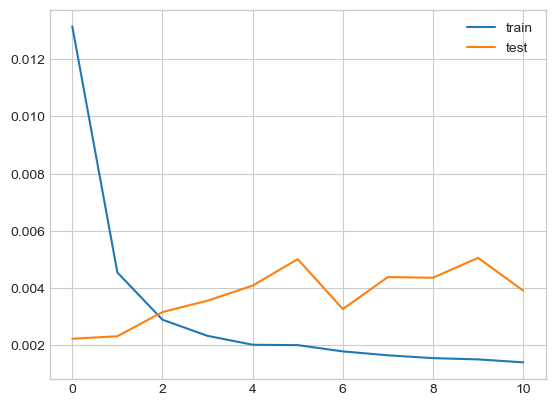

In [292]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [293]:
simpleRNN_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mse_metrics = ["Adam", "MSE"] + simpleRNN_adam_mse["metrics"]

85/85 [==============================] - 2s 6ms/step
Test MAE: 1.740
Test MSE: 4.114
Test RMSE: 2.028
Test R2: 0.800


##### Optimizer: Adam, Loss: MAE

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_76 (SimpleRNN)   (None, 1, 50)             2800      
                                                                 
 dropout_47 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_77 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_48 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_78 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_49 (Dropout)        (None, 50)                0         
                                                                 
 dense_85 (Dense)            (None, 1)               

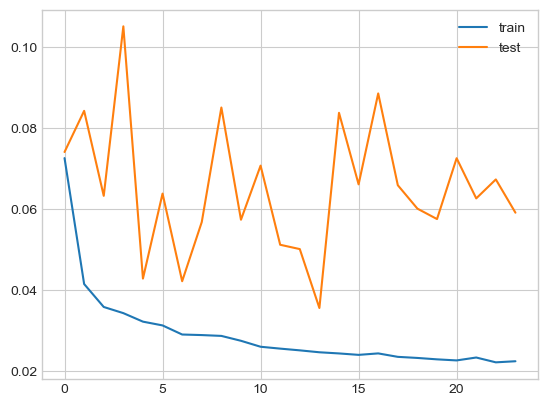

In [294]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [295]:
simpleRNN_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mae_metrics = ["Adam", "MAE"] + simpleRNN_adam_mae["metrics"]

85/85 [==============================] - 2s 4ms/step
Test MAE: 0.741
Test MSE: 0.915
Test RMSE: 0.956
Test R2: 0.956


##### Optimizer: SGD, Loss: MSE

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_79 (SimpleRNN)   (None, 1, 50)             2800      
                                                                 
 dropout_50 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_80 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_51 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_81 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_52 (Dropout)        (None, 50)                0         
                                                                 
 dense_86 (Dense)            (None, 1)               

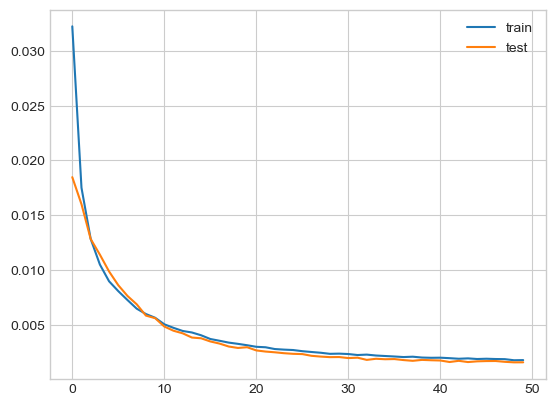

In [296]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mse')

In [297]:
simpleRNN_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mse_metrics = ["SGD", "MSE"] + simpleRNN_sgd_mse["metrics"]

85/85 [==============================] - 1s 3ms/step
Test MAE: 0.795
Test MSE: 1.084
Test RMSE: 1.041
Test R2: 0.947


##### Optimizer: SGD, Loss: MAE

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_82 (SimpleRNN)   (None, 1, 50)             2800      
                                                                 
 dropout_53 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_83 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_54 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_84 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_55 (Dropout)        (None, 50)                0         
                                                                 
 dense_87 (Dense)            (None, 1)               

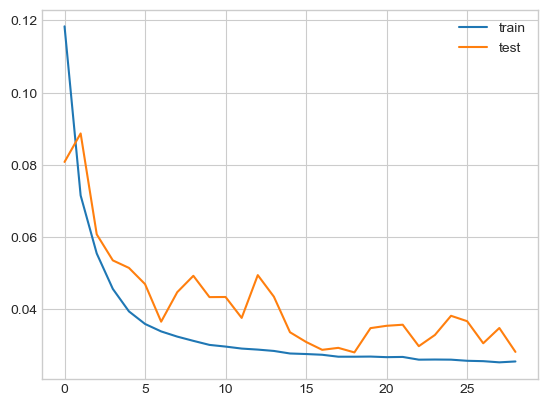

In [298]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mae')

In [299]:
simpleRNN_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mae_metrics = ["SGD", "MAE"] + simpleRNN_sgd_mae["metrics"]

85/85 [==============================] - 1s 3ms/step
Test MAE: 0.923
Test MSE: 1.307
Test RMSE: 1.143
Test R2: 0.937


##### Optimizer: Adamax, Loss: MSE

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_85 (SimpleRNN)   (None, 1, 50)             2800      
                                                                 
 dropout_56 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_86 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_57 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_87 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_58 (Dropout)        (None, 50)                0         
                                                                 
 dense_88 (Dense)            (None, 1)               

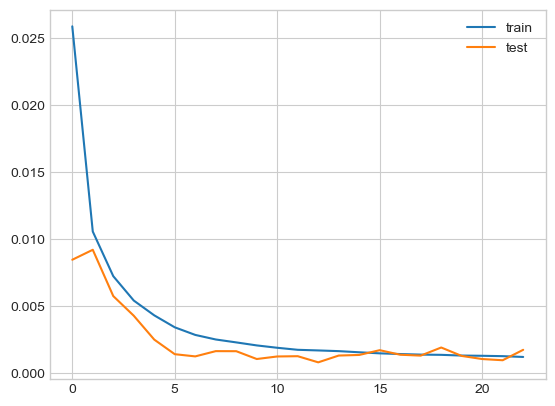

In [300]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [301]:
simpleRNN_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mse_metrics = ["Adamax", "MSE"] + simpleRNN_adamax_mse["metrics"]

85/85 [==============================] - 1s 3ms/step
Test MAE: 0.684
Test MSE: 0.805
Test RMSE: 0.897
Test R2: 0.961


##### Optimizer: Adamax, Loss: MAE

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_88 (SimpleRNN)   (None, 1, 50)             2800      
                                                                 
 dropout_59 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_89 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_60 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_90 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_61 (Dropout)        (None, 50)                0         
                                                                 
 dense_89 (Dense)            (None, 1)               

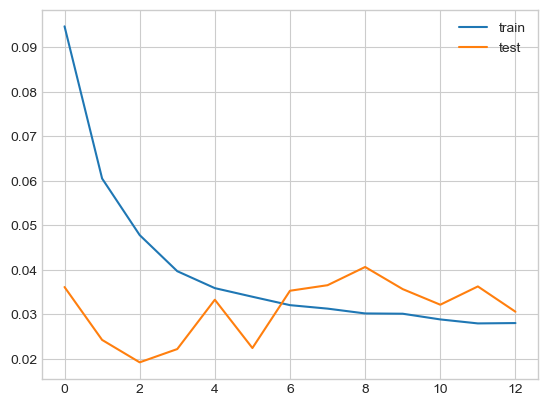

In [302]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [303]:
simpleRNN_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mae_metrics = ["Adamax", "MAE"] + simpleRNN_adamax_mae["metrics"]

85/85 [==============================] - 1s 3ms/step
Test MAE: 0.952
Test MSE: 1.390
Test RMSE: 1.179
Test R2: 0.933


#### LSTM 

##### Optimizer: Adam, Loss: MSE

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1, 50)             11200     
                                                                 
 dropout_62 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_63 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dense_90 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 516

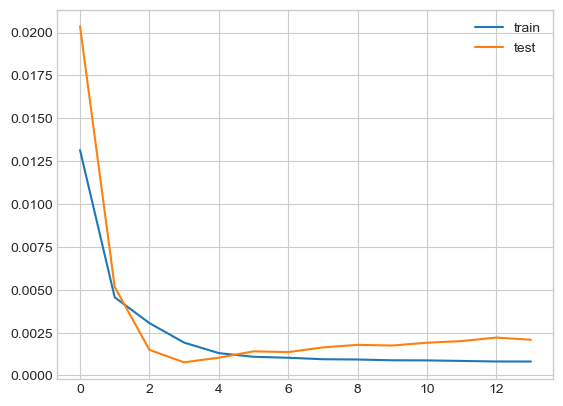

In [304]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adam', 'mse')

In [305]:
LSTM_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mse_metrics = ["Adam", "MSE"] + LSTM_adam_mse["metrics"]

85/85 [==============================] - 4s 3ms/step
Test MAE: 1.205
Test MSE: 2.024
Test RMSE: 1.423
Test R2: 0.902


##### Optimizer: Adam, Loss: MAE

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 50)             11200     
                                                                 
 dropout_64 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_31 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_65 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_32 (LSTM)              (None, 50)                20200     
                                                                 
 dense_91 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 516

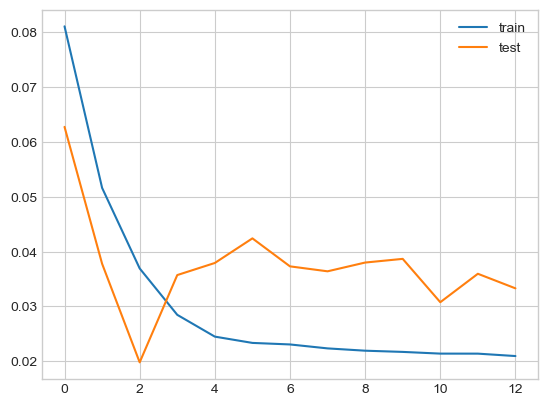

In [306]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adam', 'mae')

In [307]:
LSTM_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mae_metrics = ["Adam", "MAE"] + LSTM_adam_mae["metrics"]

85/85 [==============================] - 4s 4ms/step
Test MAE: 0.807
Test MSE: 1.089
Test RMSE: 1.044
Test R2: 0.947


##### Optimizer: SGD, Loss: MSE

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1, 50)             11200     
                                                                 
 dropout_66 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_67 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_35 (LSTM)              (None, 50)                20200     
                                                                 
 dense_92 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 51

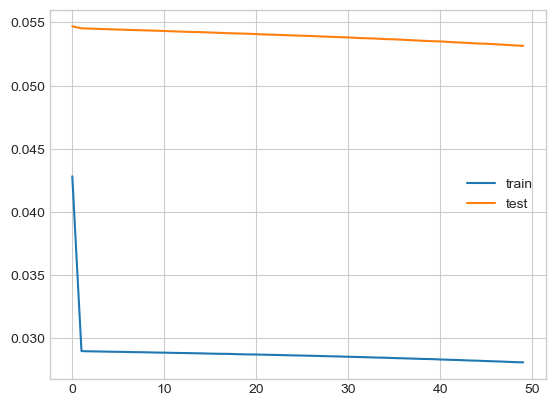

In [308]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mse')

In [309]:
LSTM_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mse_metrics = ["SGD", "MSE"] + LSTM_sgd_mse["metrics"]

85/85 [==============================] - 4s 3ms/step
Test MAE: 3.918
Test MSE: 22.290
Test RMSE: 4.721
Test R2: -0.081


##### Optimizer: SGD, Loss: MAE

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1, 50)             11200     
                                                                 
 dropout_68 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_37 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_69 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_38 (LSTM)              (None, 50)                20200     
                                                                 
 dense_93 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 51

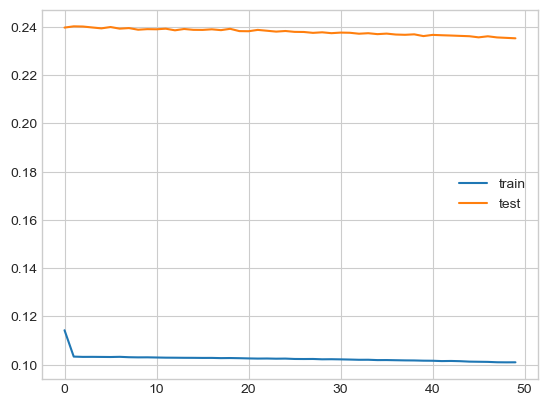

In [310]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mae')

In [311]:
LSTM_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mae_metrics = ["SGD", "MAE"] + LSTM_sgd_mae["metrics"]

85/85 [==============================] - 5s 3ms/step
Test MAE: 3.598
Test MSE: 21.761
Test RMSE: 4.665
Test R2: -0.056


##### Optimizer: Adamax, Loss: MSE

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 1, 50)             11200     
                                                                 
 dropout_70 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_40 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_71 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dense_94 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 51

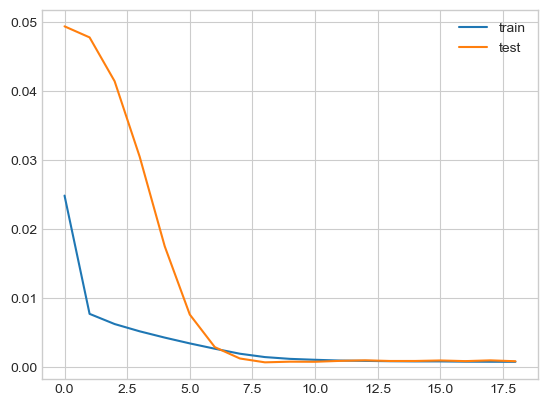

In [312]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mse')

In [313]:
LSTM_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mse_metrics = ["Adamax", "MSE"] + LSTM_adamax_mse["metrics"]

85/85 [==============================] - 4s 3ms/step
Test MAE: 0.988
Test MSE: 1.485
Test RMSE: 1.218
Test R2: 0.928


##### Optimizer: Adamax, Loss: MAE

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 1, 50)             11200     
                                                                 
 dropout_72 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_43 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_73 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_44 (LSTM)              (None, 50)                20200     
                                                                 
 dense_95 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 51

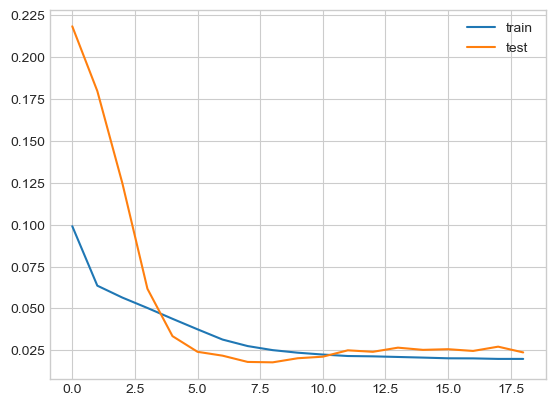

In [314]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mae')

In [315]:
LSTM_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mae_metrics = ["Adamax", "MAE"] + LSTM_adamax_mae["metrics"]

85/85 [==============================] - 4s 4ms/step
Test MAE: 0.964
Test MSE: 1.449
Test RMSE: 1.204
Test R2: 0.930


#### GRU

##### Optimizer: Adam, Loss: MSE

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 1, 100)            32100     
                                                                 
 dropout_74 (Dropout)        (None, 1, 100)            0         
                                                                 
 gru_38 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_75 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_39 (GRU)                (None, 50)                15300     
                                                                 
 dropout_76 (Dropout)        (None, 50)                0         
                                                                 
 dense_96 (Dense)            (None, 1)              

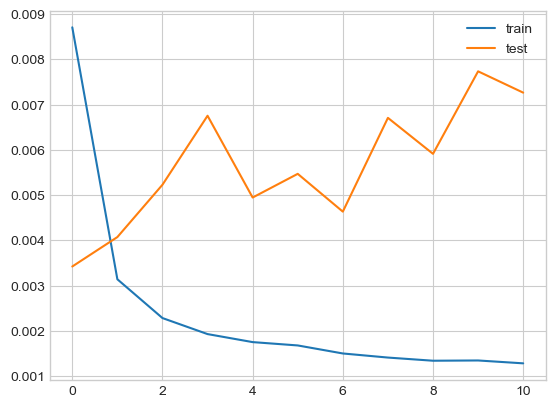

In [316]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [317]:
GRU_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mse_metrics = ["Adam", "MSE"] + GRU_adam_mse["metrics"]

85/85 [==============================] - 3s 3ms/step
Test MAE: 1.858
Test MSE: 4.639
Test RMSE: 2.154
Test R2: 0.775


##### Optimizer: Adam, Loss: MAE

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_40 (GRU)                (None, 1, 100)            32100     
                                                                 
 dropout_77 (Dropout)        (None, 1, 100)            0         
                                                                 
 gru_41 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_78 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_42 (GRU)                (None, 50)                15300     
                                                                 
 dropout_79 (Dropout)        (None, 50)                0         
                                                                 
 dense_97 (Dense)            (None, 1)              

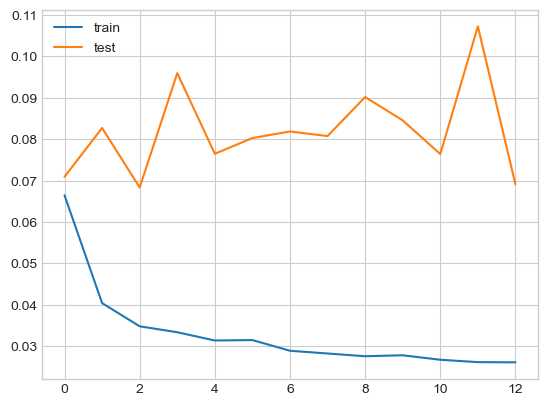

In [318]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [319]:
GRU_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mae_metrics = ["Adam", "MAE"] + GRU_adam_mae["metrics"]

85/85 [==============================] - 5s 5ms/step
Test MAE: 1.097
Test MSE: 1.910
Test RMSE: 1.382
Test R2: 0.907


##### Optimizer: SGD, Loss: MSE

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_43 (GRU)                (None, 1, 100)            32100     
                                                                 
 dropout_80 (Dropout)        (None, 1, 100)            0         
                                                                 
 gru_44 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_81 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_45 (GRU)                (None, 50)                15300     
                                                                 
 dropout_82 (Dropout)        (None, 50)                0         
                                                                 
 dense_98 (Dense)            (None, 1)              

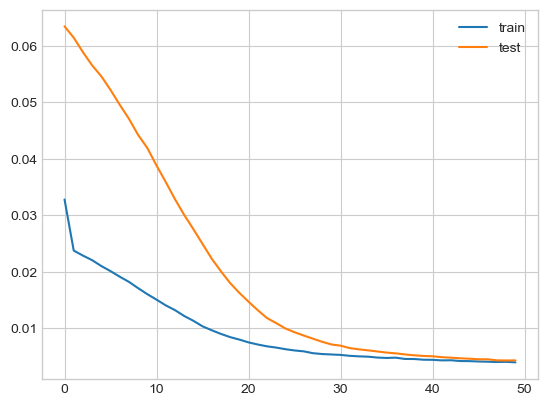

In [320]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mse')

In [321]:
GRU_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mse_metrics = ["SGD", "MSE"] + GRU_sgd_mse["metrics"]

85/85 [==============================] - 3s 3ms/step
Test MAE: 1.566
Test MSE: 4.045
Test RMSE: 2.011
Test R2: 0.804


##### Optimizer: SGD, Loss: MAE

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_46 (GRU)                (None, 1, 100)            32100     
                                                                 
 dropout_83 (Dropout)        (None, 1, 100)            0         
                                                                 
 gru_47 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_84 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_48 (GRU)                (None, 50)                15300     
                                                                 
 dropout_85 (Dropout)        (None, 50)                0         
                                                                 
 dense_99 (Dense)            (None, 1)              

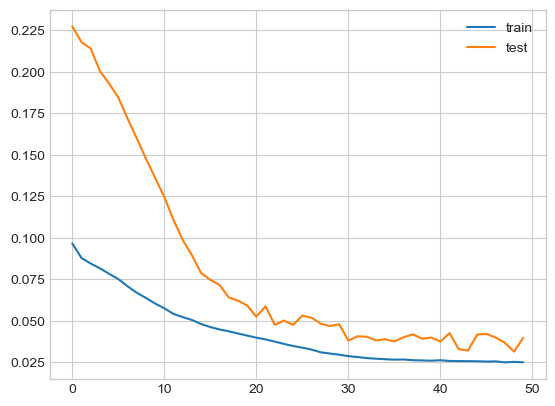

In [322]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mae')

In [323]:
GRU_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mae_metrics = ["SGD", "MAE"] + GRU_sgd_mae["metrics"]

85/85 [==============================] - 5s 5ms/step
Test MAE: 0.889
Test MSE: 1.228
Test RMSE: 1.108
Test R2: 0.940


##### Optimizer: Adamax, Loss: MSE

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_49 (GRU)                (None, 1, 100)            32100     
                                                                 
 dropout_86 (Dropout)        (None, 1, 100)            0         
                                                                 
 gru_50 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_87 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_51 (GRU)                (None, 50)                15300     
                                                                 
 dropout_88 (Dropout)        (None, 50)                0         
                                                                 
 dense_100 (Dense)           (None, 1)              

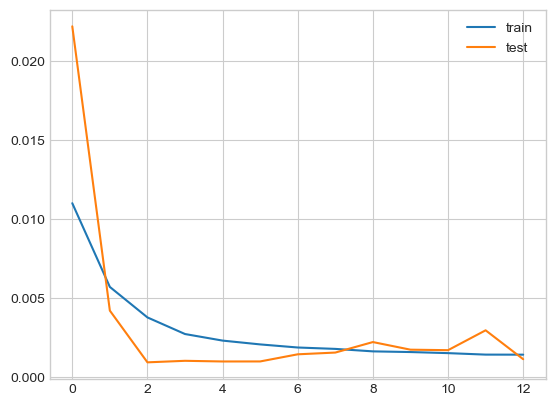

In [324]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [325]:
GRU_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mse_metrics = ["Adamax", "MSE"] + GRU_adamax_mse["metrics"]

85/85 [==============================] - 4s 4ms/step
Test MAE: 1.187
Test MSE: 1.965
Test RMSE: 1.402
Test R2: 0.905


##### Optimizer: Adamax, Loss: MAE

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_52 (GRU)                (None, 1, 100)            32100     
                                                                 
 dropout_89 (Dropout)        (None, 1, 100)            0         
                                                                 
 gru_53 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_90 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_54 (GRU)                (None, 50)                15300     
                                                                 
 dropout_91 (Dropout)        (None, 50)                0         
                                                                 
 dense_101 (Dense)           (None, 1)              

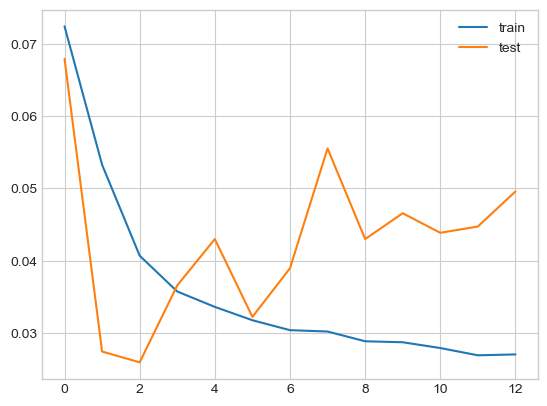

In [326]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [327]:
GRU_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mae_metrics = ["Adamax", "MAE"] + GRU_adamax_mae["metrics"]

85/85 [==============================] - 4s 4ms/step
Test MAE: 0.859
Test MSE: 1.202
Test RMSE: 1.096
Test R2: 0.942


#### Results

In [328]:
columns = ["OPTIMIZER", "LOSS", "MAE", "MSE", "RMSE", "R2"]
indexes = []
values = []

simpleRNN_res = [simpleRNN_adam_mse_metrics, simpleRNN_adam_mae_metrics, 
                 simpleRNN_sgd_mse_metrics, simpleRNN_sgd_mae_metrics, 
                 simpleRNN_adamax_mse_metrics, simpleRNN_adamax_mae_metrics]
LSTM_res = [LSTM_adam_mse_metrics, LSTM_adam_mae_metrics, 
            LSTM_sgd_mse_metrics, LSTM_sgd_mae_metrics,
            LSTM_adamax_mse_metrics, LSTM_adamax_mae_metrics]
GRU_res = [GRU_adam_mse_metrics, GRU_adam_mae_metrics,
           GRU_sgd_mse_metrics, GRU_sgd_mae_metrics, 
           GRU_adamax_mse_metrics, GRU_adamax_mae_metrics]

for r in simpleRNN_res:
    indexes.append("Simple RNN")
    values.append(r)
for r in LSTM_res:
    indexes.append("LSTM")
    values.append(r)
for r in GRU_res:
    indexes.append("GRU")
    values.append(r)

univariate_res = pd.DataFrame(values, columns=columns)
univariate_res.index = indexes

In [329]:
univariate_res

OPTIMIZER LOSS       MAE        MSE      RMSE        R2
Simple RNN      Adam  MSE  1.739981   4.113664  2.028217  0.800410
Simple RNN      Adam  MAE  0.741254   0.914585  0.956339  0.955625
Simple RNN       SGD  MSE  0.794628   1.083955  1.041131  0.947408
Simple RNN       SGD  MAE  0.923072   1.306636  1.143082  0.936603
Simple RNN    Adamax  MSE  0.683917   0.805164  0.897309  0.960934
Simple RNN    Adamax  MAE  0.952144   1.389591  1.178809  0.932579
LSTM            Adam  MSE  1.205232   2.023690  1.422564  0.901813
LSTM            Adam  MAE  0.806559   1.089464  1.043774  0.947140
LSTM             SGD  MSE  3.917790  22.289719  4.721199 -0.081473
LSTM             SGD  MAE  3.597726  21.760882  4.664856 -0.055814
LSTM          Adamax  MSE  0.988273   1.484569  1.218429  0.927970
LSTM          Adamax  MAE  0.964271   1.449271  1.203857  0.929683
GRU             Adam  MSE  1.857802   4.638598  2.153740  0.774940
GRU             Adam  MAE  1.097192   1.910208  1.382103  0.907319
GRU              SGD  MSE  1.565959   4.044899  2.011193  0.803746
GRU              SGD  MAE  0.888901   1.228305  1.108289  0.940404
GRU           Adamax  MSE  1.186826   1.965499  1.401962  0.904636
GRU           Adamax  MAE  0.858886   1.202070  1.096389  0.941677

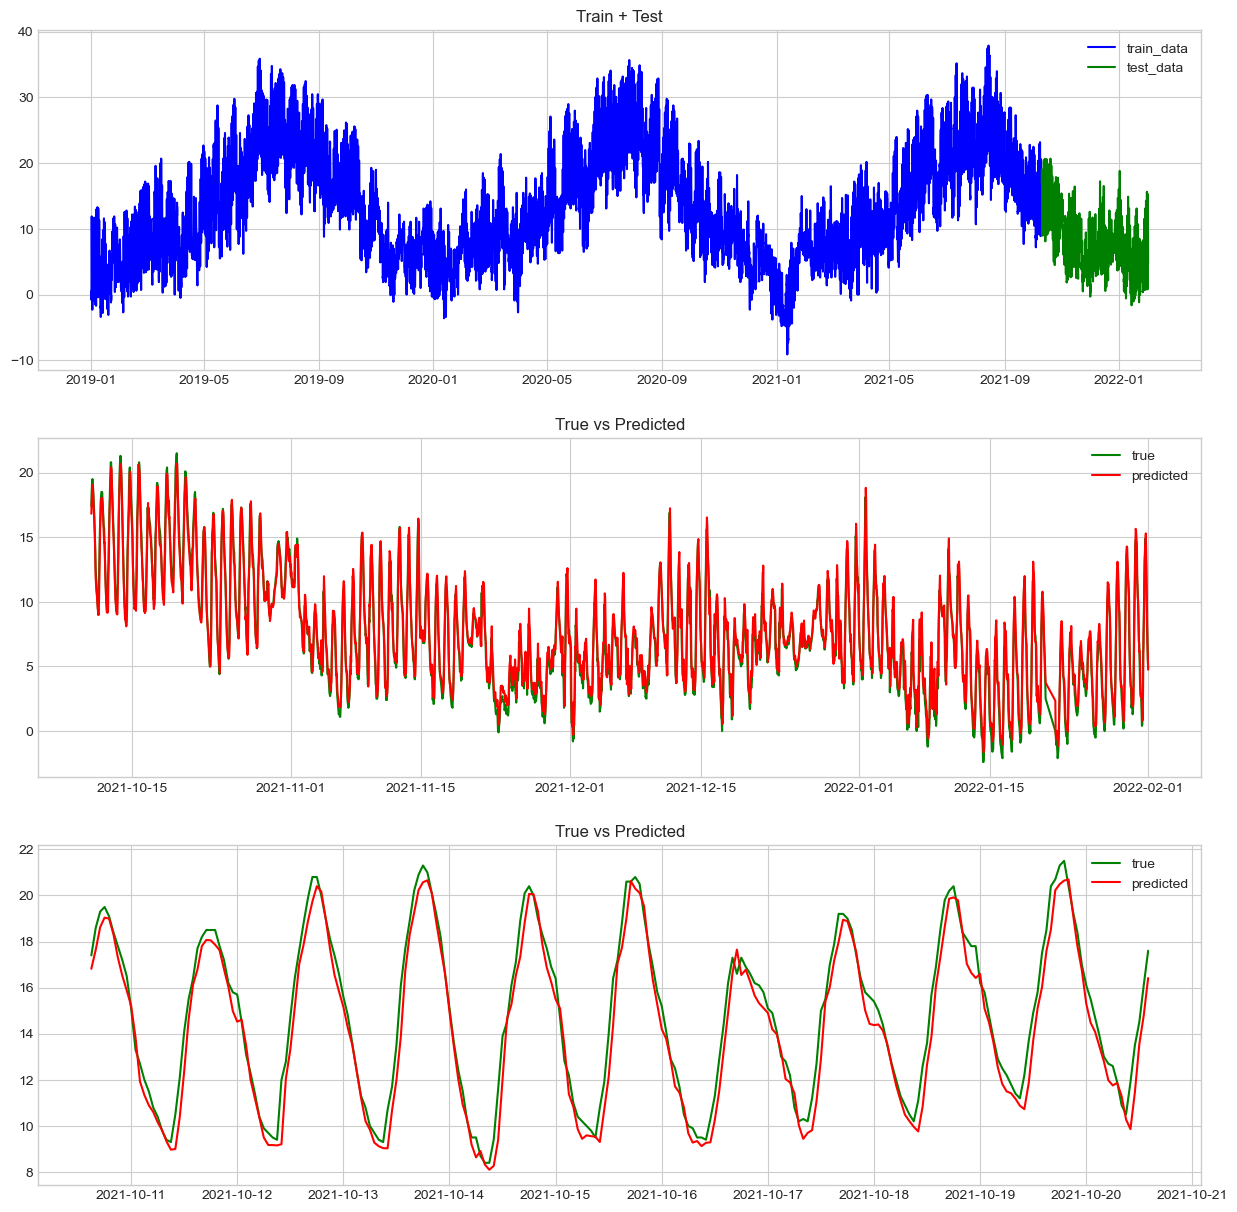

In [330]:
visualize_predictions(reframed.index, prepared_data["n_train_hours"], prepared_data["inv_train_y"], simpleRNN_adamax_mse["inv_y"], simpleRNN_adamax_mse["inv_pred_y"])

### Multivariate forecasting

In [331]:
reframed = series_to_supervised(data, data.index, 5, 1)

In [170]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27019 entries, 2019-01-01 05:59:59 to 2022-01-31 23:59:59
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-5)  27019 non-null  float64
 1   var2(t-5)  27019 non-null  float64
 2   var3(t-5)  27019 non-null  float64
 3   var4(t-5)  27019 non-null  float64
 4   var5(t-5)  27019 non-null  float64
 5   var1(t-4)  27019 non-null  float64
 6   var2(t-4)  27019 non-null  float64
 7   var3(t-4)  27019 non-null  float64
 8   var4(t-4)  27019 non-null  float64
 9   var5(t-4)  27019 non-null  float64
 10  var1(t-3)  27019 non-null  float64
 11  var2(t-3)  27019 non-null  float64
 12  var3(t-3)  27019 non-null  float64
 13  var4(t-3)  27019 non-null  float64
 14  var5(t-3)  27019 non-null  float64
 15  var1(t-2)  27019 non-null  float64
 16  var2(t-2)  27019 non-null  float64
 17  var3(t-2)  27019 non-null  float64
 18  var4(t-2)  27019 non-null  float64
 19  var5(t-2)  

In [332]:
reframed.drop(reframed.columns[[26, 27, 28, 29]], axis=1, inplace=True)

In [172]:
reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  \
time                                                                         
2019-01-01 05:59:59        3.1       50.0      949.0        0.0   0.284941   
2019-01-01 06:59:59        2.9       49.0      949.0        0.0   0.805646   
2019-01-01 07:59:59        3.1       46.0      949.0        0.0   0.408440   
2019-01-01 08:59:59        1.9       51.0      949.0        0.0   0.188938   
2019-01-01 09:59:59        0.7       56.0      949.0        0.0   0.343035   

                     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  \
time                                                                         
2019-01-01 05:59:59        2.9       49.0      949.0        0.0   0.805646   
2019-01-01 06:59:59        3.1       46.0      949.0        0.0   0.408440   
2019-01-01 07:59:59        1.9       51.0      949.0        0.0   0.188938   
2019-01-01 08:59:59        0.7       56.0      949.0        0.0   0.343035   
2019-01-01 09:59:59        0.5       53.0      949.0        0.0   0.520721   

                     ...  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  \
time                 ...                                               
2019-01-01 05:59:59  ...       51.0      949.0        0.0   0.188938   
2019-01-01 06:59:59  ...       56.0      949.0        0.0   0.343035   
2019-01-01 07:59:59  ...       53.0      949.0        0.0   0.520721   
2019-01-01 08:59:59  ...       55.0      949.0        0.0   0.772741   
2019-01-01 09:59:59  ...       60.0      949.0        0.0   0.176725   

                     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
time                                                                         
2019-01-01 05:59:59        0.7       56.0      949.0        0.0   0.343035   
2019-01-01 06:59:59        0.5       53.0      949.0        0.0   0.520721   
2019-01-01 07:59:59        0.0       55.0      949.0        0.0   0.772741   
2019-01-01 08:59:59       -0.8       60.0      949.0        0.0   0.176725   
2019-01-01 09:59:59        0.0       56.0      949.0       10.0   0.746134   

                     var1(t)  
time                          
2019-01-01 05:59:59      0.5  
2019-01-01 06:59:59      0.0  
2019-01-01 07:59:59     -0.8  
2019-01-01 08:59:59      0.0  
2019-01-01 09:59:59      2.2  

[5 rows x 26 columns]

In [333]:
prepared_data = prepare_dataset(reframed)

(18916, 1, 25) (18916,) (2698, 1, 25) (2698,) (5405, 1, 25) (5405,)


#### SimpleRNN

##### Optimizer: Adam, Loss: MSE

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_91 (SimpleRNN)   (None, 1, 50)             3800      
                                                                 
 dropout_92 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_92 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_93 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_93 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_94 (Dropout)        (None, 50)                0         
                                                                 
 dense_102 (Dense)           (None, 1)              

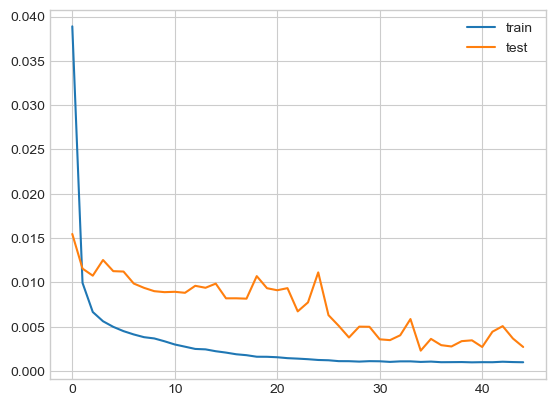

In [334]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [335]:
simpleRNN_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mse_metrics = ["Adam", "MSE"] + simpleRNN_adam_mse["metrics"]

85/85 [==============================] - 3s 7ms/step
Test MAE: 0.762
Test MSE: 0.949
Test RMSE: 0.974
Test R2: 0.954


##### Optimizer: Adam, Loss: MAE

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_94 (SimpleRNN)   (None, 1, 50)             3800      
                                                                 
 dropout_95 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_95 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_96 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_96 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_97 (Dropout)        (None, 50)                0         
                                                                 
 dense_103 (Dense)           (None, 1)              

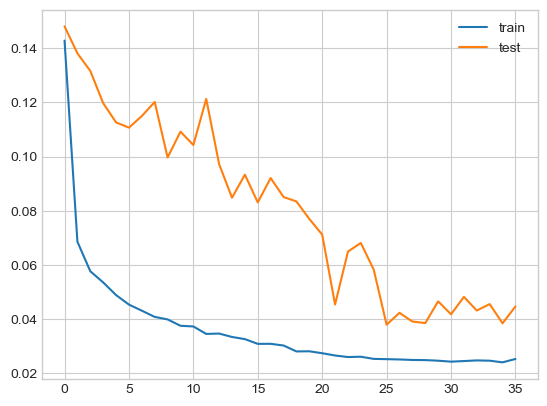

In [336]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [337]:
simpleRNN_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mae_metrics = ["Adam", "MAE"] + simpleRNN_adam_mae["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 0.728
Test MSE: 0.886
Test RMSE: 0.941
Test R2: 0.957


##### Optimizer: SGD, Loss: MSE

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_97 (SimpleRNN)   (None, 1, 50)             3800      
                                                                 
 dropout_98 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_98 (SimpleRNN)   (None, 1, 50)             5050      
                                                                 
 dropout_99 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_99 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_100 (Dropout)       (None, 50)                0         
                                                                 
 dense_104 (Dense)           (None, 1)              

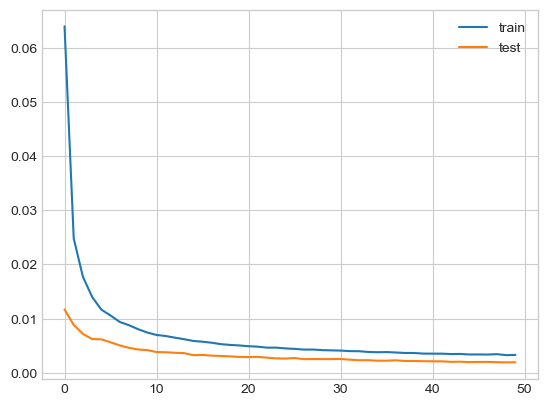

In [338]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mse')

In [339]:
simpleRNN_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mse_metrics = ["SGD", "MSE"] + simpleRNN_sgd_mse["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 1.209
Test MSE: 2.228
Test RMSE: 1.493
Test R2: 0.892


##### Optimizer: SGD, Loss: MAE

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_100 (SimpleRNN)  (None, 1, 50)             3800      
                                                                 
 dropout_101 (Dropout)       (None, 1, 50)             0         
                                                                 
 simple_rnn_101 (SimpleRNN)  (None, 1, 50)             5050      
                                                                 
 dropout_102 (Dropout)       (None, 1, 50)             0         
                                                                 
 simple_rnn_102 (SimpleRNN)  (None, 50)                5050      
                                                                 
 dropout_103 (Dropout)       (None, 50)                0         
                                                                 
 dense_105 (Dense)           (None, 1)              

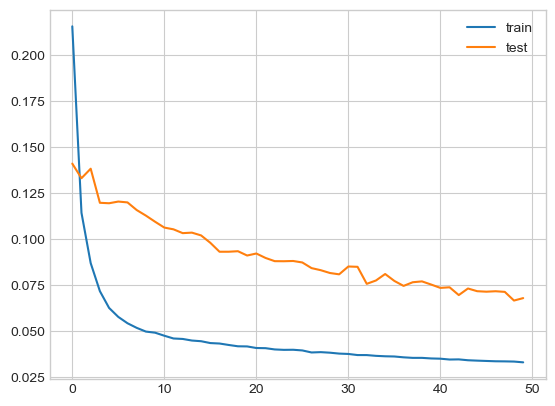

In [340]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mae')

In [341]:
simpleRNN_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mae_metrics = ["SGD", "MAE"] + simpleRNN_sgd_mae["metrics"]

85/85 [==============================] - 2s 4ms/step
Test MAE: 1.272
Test MSE: 2.541
Test RMSE: 1.594
Test R2: 0.877


##### Optimizer: Adamax, Loss: MSE

Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_103 (SimpleRNN)  (None, 1, 50)             3800      
                                                                 
 dropout_104 (Dropout)       (None, 1, 50)             0         
                                                                 
 simple_rnn_104 (SimpleRNN)  (None, 1, 50)             5050      
                                                                 
 dropout_105 (Dropout)       (None, 1, 50)             0         
                                                                 
 simple_rnn_105 (SimpleRNN)  (None, 50)                5050      
                                                                 
 dropout_106 (Dropout)       (None, 50)                0         
                                                                 
 dense_106 (Dense)           (None, 1)              

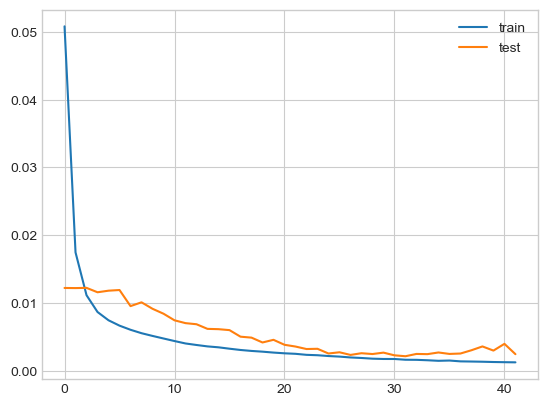

In [342]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [343]:
simpleRNN_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mse_metrics = ["Adamax", "MSE"] + simpleRNN_adamax_mse["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 0.896
Test MSE: 1.294
Test RMSE: 1.137
Test R2: 0.937


##### Optimizer: Adamax, Loss: MAE

Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_106 (SimpleRNN)  (None, 1, 50)             3800      
                                                                 
 dropout_107 (Dropout)       (None, 1, 50)             0         
                                                                 
 simple_rnn_107 (SimpleRNN)  (None, 1, 50)             5050      
                                                                 
 dropout_108 (Dropout)       (None, 1, 50)             0         
                                                                 
 simple_rnn_108 (SimpleRNN)  (None, 50)                5050      
                                                                 
 dropout_109 (Dropout)       (None, 50)                0         
                                                                 
 dense_107 (Dense)           (None, 1)              

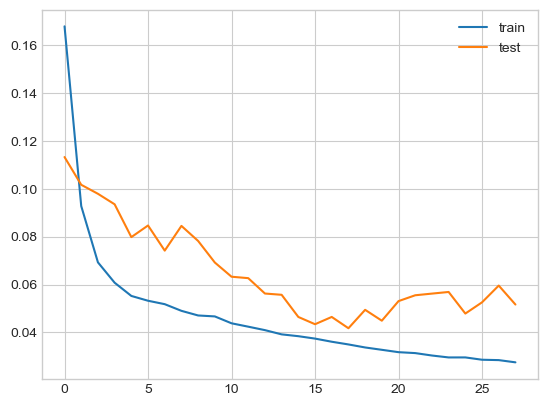

In [344]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [345]:
simpleRNN_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mae_metrics = ["Adamax", "MAE"] + simpleRNN_adamax_mae["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 0.952
Test MSE: 1.430
Test RMSE: 1.196
Test R2: 0.931


#### LSTM

##### Optimizer: Adam, Loss: MSE

Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 1, 50)             15200     
                                                                 
 dropout_110 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_46 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_111 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_47 (LSTM)              (None, 50)                20200     
                                                                 
 dense_108 (Dense)           (None, 1)                 51        
                                                                 
Total params: 55651 (217.39 KB)
Trainable params: 55

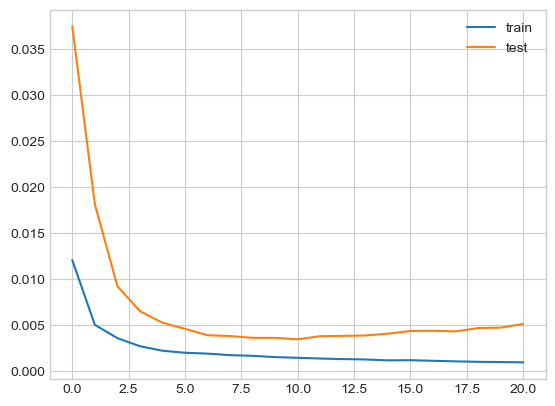

In [346]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [347]:
LSTM_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mse_metrics = ["Adam", "MSE"] + LSTM_adam_mse["metrics"]

85/85 [==============================] - 7s 7ms/step
Test MAE: 1.133
Test MSE: 2.019
Test RMSE: 1.421
Test R2: 0.902


##### Optimizer: Adam, Loss: MAE

Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 1, 50)             15200     
                                                                 
 dropout_112 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_49 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_113 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_50 (LSTM)              (None, 50)                20200     
                                                                 
 dense_109 (Dense)           (None, 1)                 51        
                                                                 
Total params: 55651 (217.39 KB)
Trainable params: 55

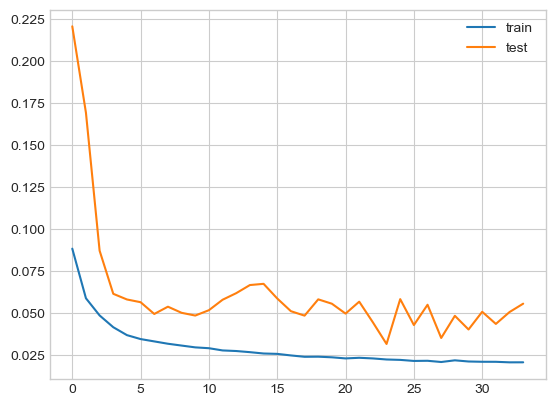

In [348]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [349]:
LSTM_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mae_metrics = ["Adam", "MAE"] + LSTM_adam_mae["metrics"]

85/85 [==============================] - 7s 9ms/step
Test MAE: 0.816
Test MSE: 1.063
Test RMSE: 1.031
Test R2: 0.948


##### Optimizer: SGD, Loss: MSE

Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 1, 50)             15200     
                                                                 
 dropout_114 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_52 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_115 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_53 (LSTM)              (None, 50)                20200     
                                                                 
 dense_110 (Dense)           (None, 1)                 51        
                                                                 
Total params: 55651 (217.39 KB)
Trainable params: 55

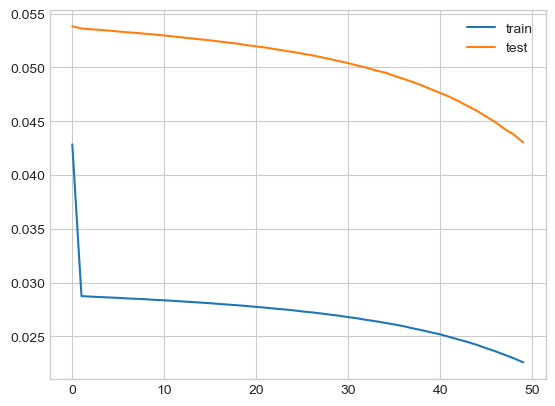

In [350]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mse')

In [351]:
LSTM_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mse_metrics = ["SGD", "MSE"] + LSTM_sgd_mse["metrics"]

85/85 [==============================] - 7s 4ms/step
Test MAE: 3.605
Test MSE: 19.081
Test RMSE: 4.368
Test R2: 0.074


##### Optimizer: SGD, Loss: MAE

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 1, 50)             15200     
                                                                 
 dropout_116 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_55 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_117 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_56 (LSTM)              (None, 50)                20200     
                                                                 
 dense_111 (Dense)           (None, 1)                 51        
                                                                 
Total params: 55651 (217.39 KB)
Trainable params: 55

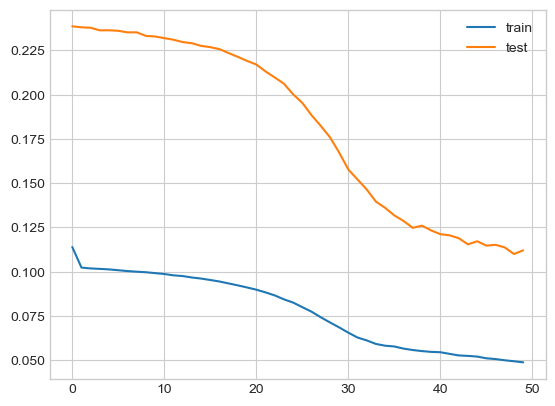

In [352]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mae')

In [353]:
LSTM_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mae_metrics = ["SGD", "MAE"] + LSTM_sgd_mae["metrics"]

85/85 [==============================] - 8s 6ms/step
Test MAE: 2.193
Test MSE: 7.319
Test RMSE: 2.705
Test R2: 0.645


##### Optimizer: Adamax, Loss: MSE

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 1, 50)             15200     
                                                                 
 dropout_118 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_58 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_119 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_59 (LSTM)              (None, 50)                20200     
                                                                 
 dense_112 (Dense)           (None, 1)                 51        
                                                                 
Total params: 55651 (217.39 KB)
Trainable params: 55

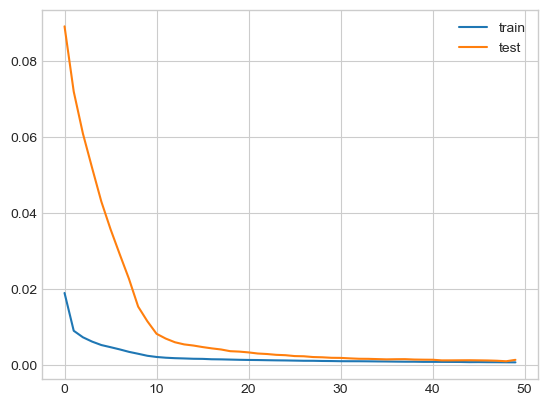

In [354]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mse')

In [355]:
LSTM_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mse_metrics = ["Adamax", "MSE"] + LSTM_adamax_mse["metrics"]

85/85 [==============================] - 8s 5ms/step
Test MAE: 0.777
Test MSE: 0.986
Test RMSE: 0.993
Test R2: 0.952


##### Optimizer: Adamax, Loss: MAE

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 1, 50)             15200     
                                                                 
 dropout_120 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_61 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_121 (Dropout)       (None, 1, 50)             0         
                                                                 
 lstm_62 (LSTM)              (None, 50)                20200     
                                                                 
 dense_113 (Dense)           (None, 1)                 51        
                                                                 
Total params: 55651 (217.39 KB)
Trainable params: 55

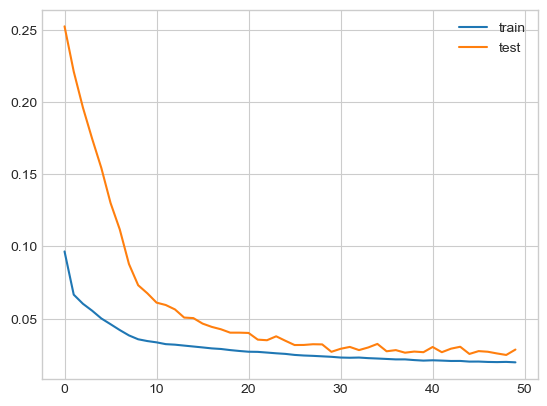

In [356]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mae')

In [357]:
LSTM_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mae_metrics = ["Adamax", "MAE"] + LSTM_adamax_mae["metrics"]

85/85 [==============================] - 7s 6ms/step
Test MAE: 0.799
Test MSE: 1.027
Test RMSE: 1.013
Test R2: 0.950


#### GRU

##### Optimizer: Adam, Loss: MSE

Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_55 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_122 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_56 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_123 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_57 (GRU)                (None, 50)                15300     
                                                                 
 dropout_124 (Dropout)       (None, 50)                0         
                                                                 
 dense_114 (Dense)           (None, 1)              

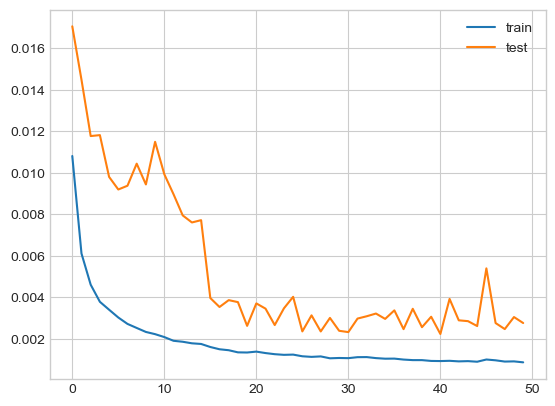

In [358]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [359]:
GRU_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mse_metrics = ["Adam", "MSE"] + GRU_adam_mse["metrics"]

85/85 [==============================] - 6s 6ms/step
Test MAE: 0.945
Test MSE: 1.387
Test RMSE: 1.178
Test R2: 0.933


##### Optimizer: Adam, Loss: MAE

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_58 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_125 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_59 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_126 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_60 (GRU)                (None, 50)                15300     
                                                                 
 dropout_127 (Dropout)       (None, 50)                0         
                                                                 
 dense_115 (Dense)           (None, 1)              

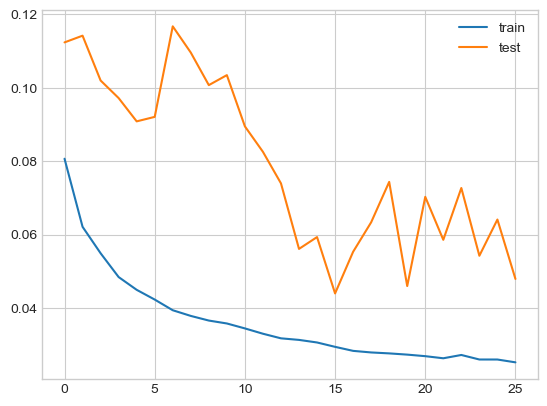

In [360]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [361]:
GRU_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mae_metrics = ["Adam", "MAE"] + GRU_adam_mae["metrics"]

85/85 [==============================] - 7s 6ms/step
Test MAE: 0.995
Test MSE: 1.541
Test RMSE: 1.241
Test R2: 0.925


##### Optimizer: SGD, Loss: MSE

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_61 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_128 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_62 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_129 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_63 (GRU)                (None, 50)                15300     
                                                                 
 dropout_130 (Dropout)       (None, 50)                0         
                                                                 
 dense_116 (Dense)           (None, 1)              

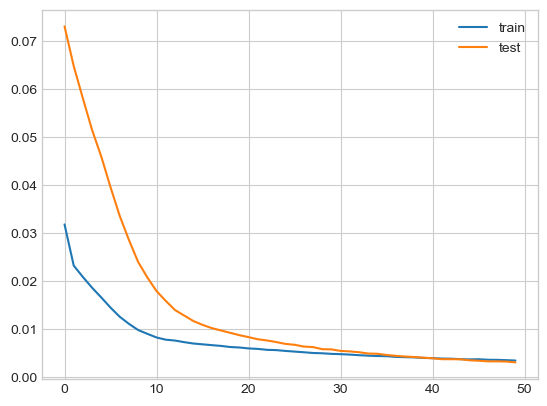

In [362]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mse')

In [363]:
GRU_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mse_metrics = ["SGD", "MSE"] + GRU_sgd_mse["metrics"]

85/85 [==============================] - 7s 6ms/step
Test MAE: 1.467
Test MSE: 3.316
Test RMSE: 1.821
Test R2: 0.839


##### Optimizer: SGD, Loss: MAE

Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_64 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_131 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_65 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_132 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_66 (GRU)                (None, 50)                15300     
                                                                 
 dropout_133 (Dropout)       (None, 50)                0         
                                                                 
 dense_117 (Dense)           (None, 1)              

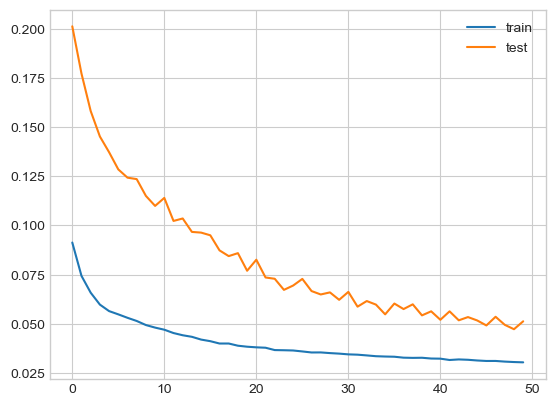

In [364]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mae')

In [365]:
GRU_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mae_metrics = ["SGD", "MAE"] + GRU_sgd_mae["metrics"]

85/85 [==============================] - 7s 5ms/step
Test MAE: 1.117
Test MSE: 1.941
Test RMSE: 1.393
Test R2: 0.906


##### Optimizer: Adamax, Loss: MSE

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_67 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_134 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_68 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_135 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_69 (GRU)                (None, 50)                15300     
                                                                 
 dropout_136 (Dropout)       (None, 50)                0         
                                                                 
 dense_118 (Dense)           (None, 1)              

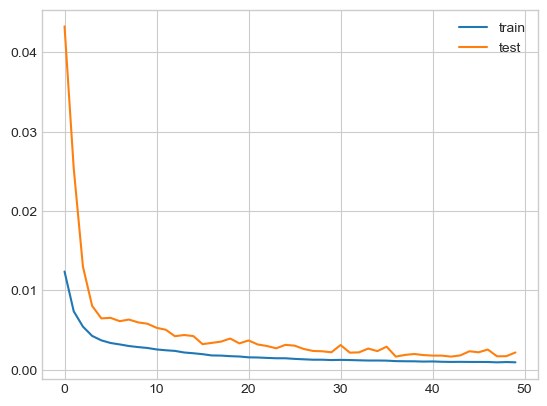

In [366]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [367]:
GRU_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mse_metrics = ["Adamax", "MSE"] + GRU_adamax_mse["metrics"]

85/85 [==============================] - 6s 6ms/step
Test MAE: 0.958
Test MSE: 1.411
Test RMSE: 1.188
Test R2: 0.932


##### Optimizer: Adamax, Loss: MAE

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_70 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_137 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_71 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_138 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_72 (GRU)                (None, 50)                15300     
                                                                 
 dropout_139 (Dropout)       (None, 50)                0         
                                                                 
 dense_119 (Dense)           (None, 1)              

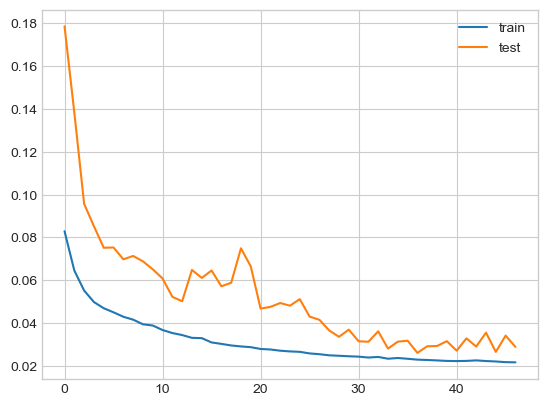

In [368]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [369]:
GRU_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mae_metrics = ["Adamax", "MAE"] + GRU_adamax_mae["metrics"]

85/85 [==============================] - 6s 7ms/step
Test MAE: 0.668
Test MSE: 0.759
Test RMSE: 0.871
Test R2: 0.963


#### Results

In [370]:
columns = ["OPTIMIZER", "LOSS", "MAE", "MSE", "RMSE", "R2"]
indexes = []
values = []

simpleRNN_res = [simpleRNN_adam_mse_metrics, simpleRNN_adam_mae_metrics, 
                 simpleRNN_sgd_mse_metrics, simpleRNN_sgd_mae_metrics, 
                 simpleRNN_adamax_mse_metrics, simpleRNN_adamax_mae_metrics]
LSTM_res = [LSTM_adam_mse_metrics, LSTM_adam_mae_metrics, 
            LSTM_sgd_mse_metrics, LSTM_sgd_mae_metrics,
            LSTM_adamax_mse_metrics, LSTM_adamax_mae_metrics]
GRU_res = [GRU_adam_mse_metrics, GRU_adam_mae_metrics,
           GRU_sgd_mse_metrics, GRU_sgd_mae_metrics, 
           GRU_adamax_mse_metrics, GRU_adamax_mae_metrics]

for r in simpleRNN_res:
    indexes.append("Simple RNN")
    values.append(r)
for r in LSTM_res:
    indexes.append("LSTM")
    values.append(r)
for r in GRU_res:
    indexes.append("GRU")
    values.append(r)

multivariate_res = pd.DataFrame(values, columns=columns)
multivariate_res.index = indexes

In [371]:
multivariate_res

OPTIMIZER LOSS       MAE        MSE      RMSE        R2
Simple RNN      Adam  MSE  0.761701   0.949486  0.974416  0.953932
Simple RNN      Adam  MAE  0.728345   0.886010  0.941281  0.957012
Simple RNN       SGD  MSE  1.208675   2.228122  1.492689  0.891894
Simple RNN       SGD  MAE  1.272276   2.540649  1.593941  0.876731
Simple RNN    Adamax  MSE  0.895549   1.293509  1.137325  0.937240
Simple RNN    Adamax  MAE  0.952158   1.429549  1.195638  0.930640
LSTM            Adam  MSE  1.133032   2.019280  1.421014  0.902027
LSTM            Adam  MAE  0.815787   1.062916  1.030978  0.948428
LSTM             SGD  MSE  3.605104  19.080927  4.368172  0.074214
LSTM             SGD  MAE  2.193147   7.319327  2.705426  0.644874
LSTM          Adamax  MSE  0.777179   0.985568  0.992758  0.952181
LSTM          Adamax  MAE  0.799093   1.026538  1.013182  0.950194
GRU             Adam  MSE  0.945398   1.386778  1.177616  0.932715
GRU             Adam  MAE  0.995073   1.540922  1.241339  0.925236
GRU              SGD  MSE  1.466964   3.315546  1.820864  0.839133
GRU              SGD  MAE  1.116643   1.940916  1.393168  0.905829
GRU           Adamax  MSE  0.957774   1.410930  1.187826  0.931543
GRU           Adamax  MAE  0.668349   0.758861  0.871126  0.963181

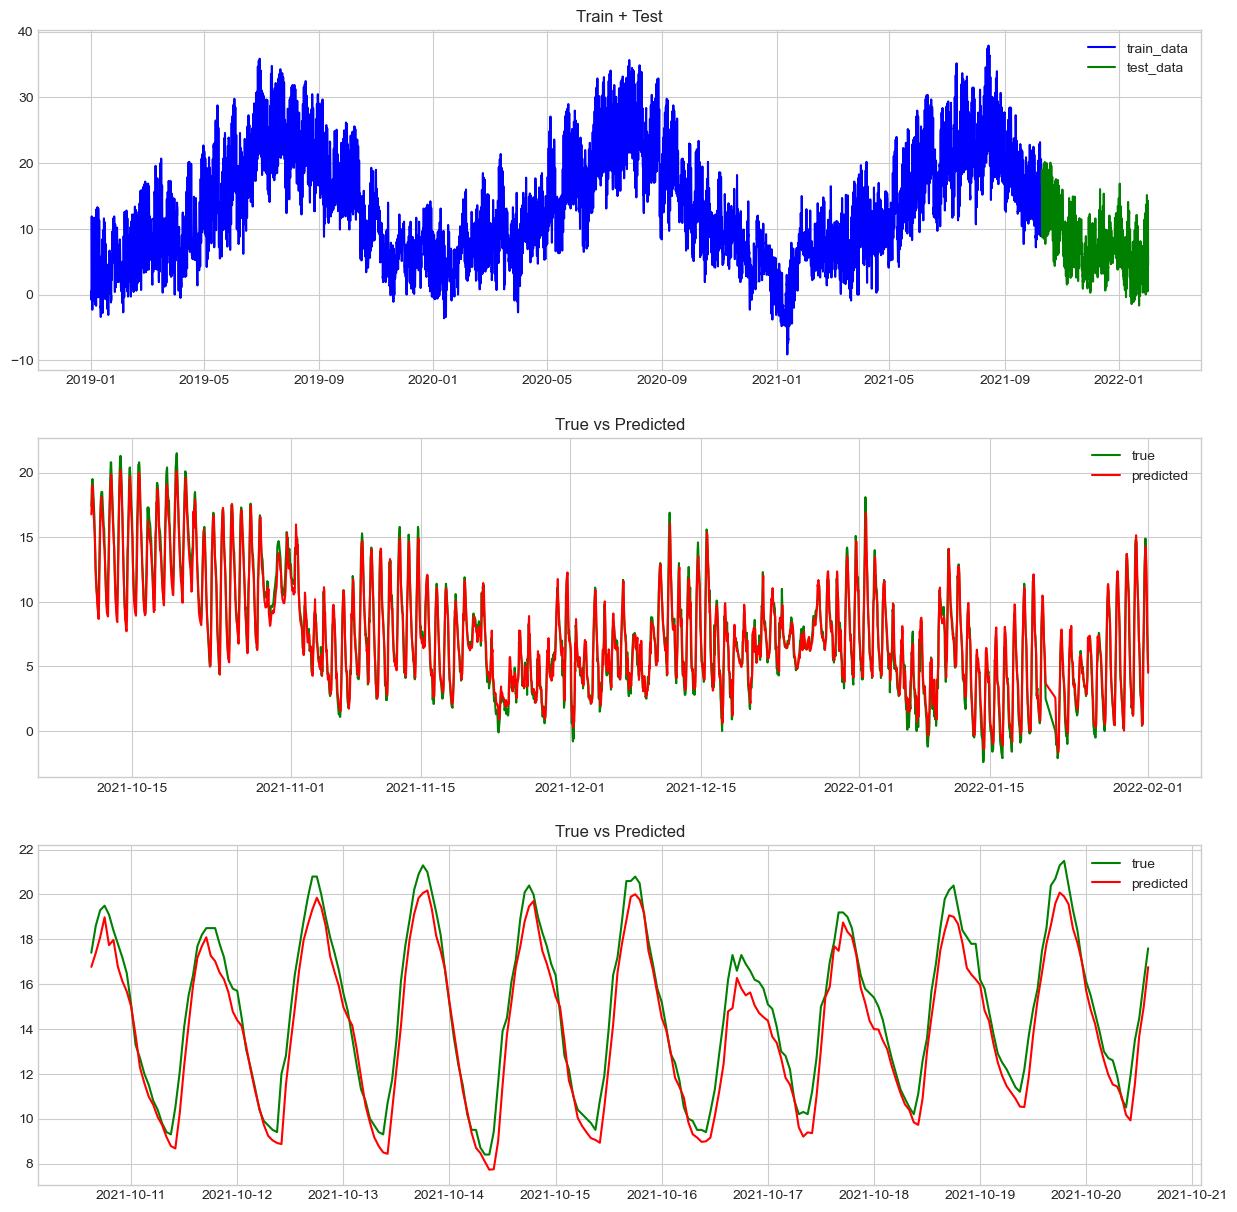

In [373]:
visualize_predictions(reframed.index, prepared_data["n_train_hours"], prepared_data["inv_train_y"], GRU_adamax_mae["inv_y"], GRU_adamax_mae["inv_pred_y"])

### Dodatna optimizacija

Najbolje rezultate nad test skupom dao je multivariate model koji sadrži GRU slojeve, koristi Adamax optimizator i MAE loss, tako da je on izabran za dalju optimizaciju. Pokušano je treniranje takve mreže sa različitim batch_size i learning_rate paramaterima, a nakon toga i sa custom loss funkcijom.

#### Optimizer: Adamax, LR: 0.001, LOSS: MAE, BATCH: 64, EPOCHS: 50

Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_73 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_140 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_74 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_141 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_75 (GRU)                (None, 50)                15300     
                                                                 
 dropout_142 (Dropout)       (None, 50)                0         
                                                                 
 dense_120 (Dense)           (None, 1)              

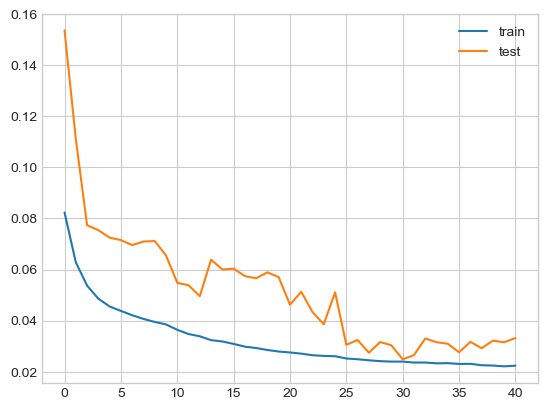

In [375]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer=keras.optimizers.Adamax(learning_rate=0.001))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=64, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [377]:
model0 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model0_metrics = ["Adamax", "0.001", "MAE", 64, 50] + model0["metrics"]

85/85 [==============================] - 0s 3ms/step
Test MAE: 0.683
Test MSE: 0.784
Test RMSE: 0.886
Test R2: 0.962


#### Optimizer: Adamax, LR: 0.001, LOSS: MAE, BATCH: 32, EPOCHS: 50

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_79 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_146 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_80 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_147 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_81 (GRU)                (None, 50)                15300     
                                                                 
 dropout_148 (Dropout)       (None, 50)                0         
                                                                 
 dense_122 (Dense)           (None, 1)              

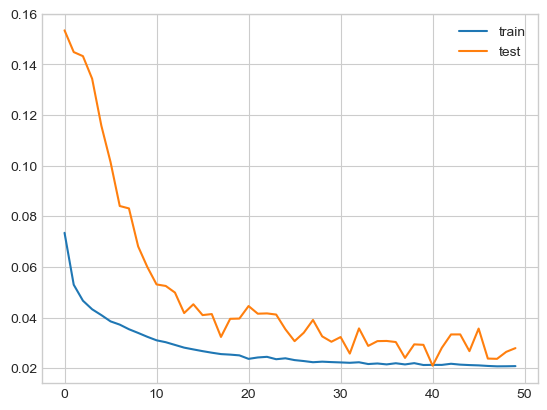

In [379]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer=keras.optimizers.Adamax(learning_rate=0.001))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=32, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [380]:
model1 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model1_metrics = ["Adamax", "0.001", "MAE", 32, 50] + model1["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 0.716
Test MSE: 0.837
Test RMSE: 0.915
Test R2: 0.959


#### Optimizer: Adamax, LR: 0.001, LOSS: MAE, BATCH: 128, EPOCHS: 50

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_82 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_149 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_83 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_150 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_84 (GRU)                (None, 50)                15300     
                                                                 
 dropout_151 (Dropout)       (None, 50)                0         
                                                                 
 dense_123 (Dense)           (None, 1)              

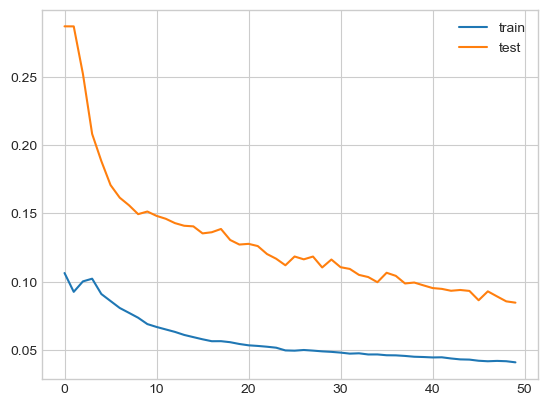

In [381]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer=keras.optimizers.Adamax(learning_rate=0.001))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=128, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [382]:
model2 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model2_metrics = ["Adamax", "0.001", "MAE", 128, 50] + model2["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 2.008
Test MSE: 5.899
Test RMSE: 2.429
Test R2: 0.714


#### Optimizer: Adamax, LR: 0.01, LOSS: MAE, BATCH: 64, EPOCHS: 50

Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_85 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_152 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_86 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_153 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_87 (GRU)                (None, 50)                15300     
                                                                 
 dropout_154 (Dropout)       (None, 50)                0         
                                                                 
 dense_124 (Dense)           (None, 1)              

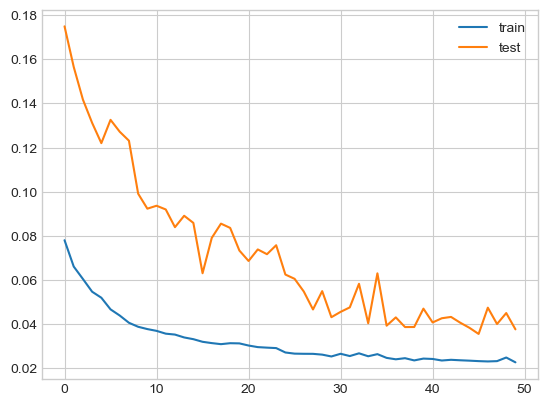

In [383]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer=keras.optimizers.Adamax(learning_rate=0.01))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=64, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [384]:
model3 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model3_metrics = ["Adamax", "0.01", "MAE", 64, 50] + model3["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 1.002
Test MSE: 1.478
Test RMSE: 1.216
Test R2: 0.928


#### Optimizer: Adamax, LR: 0.0001, LOSS: MAE, BATCH: 64, EPOCHS: 50

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_91 (GRU)                (None, 1, 100)            38100     
                                                                 
 dropout_158 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_92 (GRU)                (None, 1, 50)             22800     
                                                                 
 dropout_159 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_93 (GRU)                (None, 50)                15300     
                                                                 
 dropout_160 (Dropout)       (None, 50)                0         
                                                                 
 dense_126 (Dense)           (None, 1)              

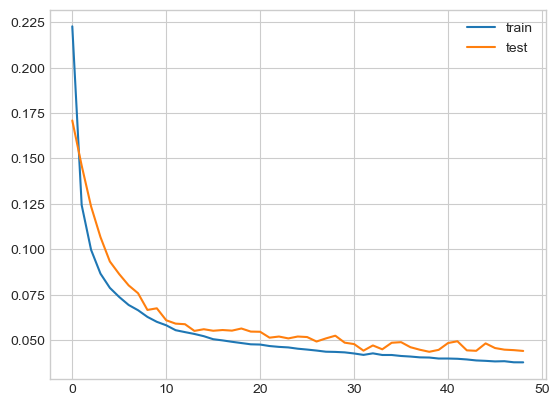

In [386]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer=keras.optimizers.Adamax(learning_rate=0.0001))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=64, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [387]:
model4 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model4_metrics = ["Adamax", "0.0001", "MAE", 64, 50] + model4["metrics"]

85/85 [==============================] - 2s 3ms/step
Test MAE: 1.263
Test MSE: 2.502
Test RMSE: 1.582
Test R2: 0.879


#### Optimizer: Adamax, LR: 0.001, LOSS: CUSTOM, BATCH: 64, EPOCHS: 50

In [428]:
def custom_loss(y_true, y_pred):
    residuals = y_true - y_pred

    squared_error = tf.square(residuals)
    temperature_weight = tf.maximum(1.0, tf.abs(y_true))
    weighted_loss = squared_error * temperature_weight
    seasonal_penalty = tf.reduce_mean(tf.square(y_true[1:] - y_true[:-1] - (y_pred[1:] - y_pred[:-1])))

    loss = tf.reduce_mean(weighted_loss) + 0.05 * seasonal_penalty 

    return loss

Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_127 (GRU)               (None, 1, 100)            38100     
                                                                 
 dropout_194 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_128 (GRU)               (None, 1, 50)             22800     
                                                                 
 dropout_195 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_129 (GRU)               (None, 50)                15300     
                                                                 
 dropout_196 (Dropout)       (None, 50)                0         
                                                                 
 dense_138 (Dense)           (None, 1)              

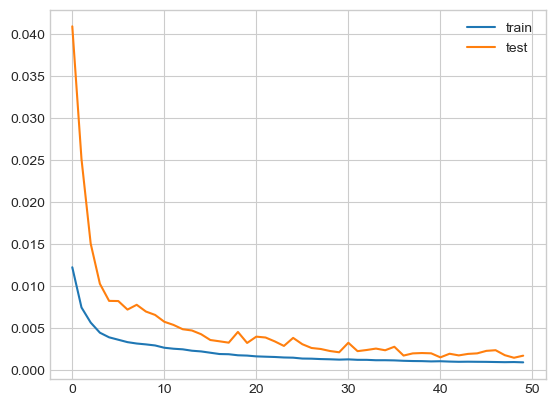

In [429]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss=custom_loss, optimizer=keras.optimizers.Adamax(learning_rate=0.001))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=64, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [430]:
model5 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model5_metrics = ["Adamax", "0.001", "CUSTOM", 64, 50] + model5["metrics"]

85/85 [==============================] - 3s 3ms/step
Test MAE: 0.830
Test MSE: 1.103
Test RMSE: 1.050
Test R2: 0.946


#### Optimizer: Adamax, LR: 0.0001, LOSS: CUSTOM, BATCH: 64, EPOCHS: 50

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_130 (GRU)               (None, 1, 100)            38100     
                                                                 
 dropout_197 (Dropout)       (None, 1, 100)            0         
                                                                 
 gru_131 (GRU)               (None, 1, 50)             22800     
                                                                 
 dropout_198 (Dropout)       (None, 1, 50)             0         
                                                                 
 gru_132 (GRU)               (None, 50)                15300     
                                                                 
 dropout_199 (Dropout)       (None, 50)                0         
                                                                 
 dense_139 (Dense)           (None, 1)              

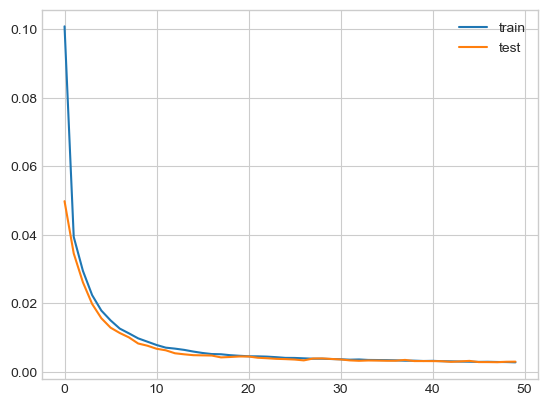

In [431]:
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(prepared_data["train_X"].shape[1], prepared_data["train_X"].shape[2])))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss=custom_loss, optimizer=keras.optimizers.Adamax(learning_rate=0.0001))
model.summary()
history = model.fit(prepared_data["train_X"], prepared_data["train_y"], epochs=50, batch_size=64, 
                    validation_data=(prepared_data["val_X"], prepared_data["val_y"]), verbose=2, shuffle=False, callbacks=get_callbacks())

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [432]:
model6 = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
model6_metrics = ["Adamax", "0.0001", "CUSTOM", 64, 50] + model6["metrics"]

85/85 [==============================] - 3s 3ms/step
Test MAE: 1.324
Test MSE: 2.716
Test RMSE: 1.648
Test R2: 0.868


#### Results

In [433]:
columns = ["OPTIMIZER", "LR", "LOSS", "BATCH", "EPOCHS", "MAE", "MSE", "RMSE", "R2"]
values = []

res = [model0_metrics, model1_metrics, model2_metrics, model3_metrics, model4_metrics, model5_metrics, model6_metrics]

for r in res:
    values.append(r)

final_res = pd.DataFrame(values, columns=columns)

In [434]:
final_res

OPTIMIZER      LR    LOSS  BATCH  EPOCHS       MAE       MSE      RMSE  \
0    Adamax   0.001     MAE     64      50  0.682663  0.784218  0.885561   
1    Adamax   0.001     MAE     32      50  0.716482  0.836987  0.914870   
2    Adamax   0.001     MAE    128      50  2.008491  5.899165  2.428820   
3    Adamax    0.01     MAE     64      50  1.002446  1.478309  1.215857   
4    Adamax  0.0001     MAE     64      50  1.263255  2.502237  1.581846   
5    Adamax   0.001  CUSTOM     64      50  0.829984  1.103032  1.050253   
6    Adamax  0.0001  CUSTOM     64      50  1.323768  2.716166  1.648080   

         R2  
0  0.961951  
1  0.959390  
2  0.713779  
3  0.928274  
4  0.878594  
5  0.946482  
6  0.868215

Pokušaji optimizacije nisu unapredili model, tako da je najbolji model polazni: model 0.